<a href="https://colab.research.google.com/github/Seba485/Deep-Learning-project/blob/DEV_Hyun/alzheimer_mri_model_tensorflow_2_3_data_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methods: project work 2023

Every new markdown cell has  'NEW:'      written before

Original markdown cells not useful are commented out "( <!-- [.]-->)"

Put your dataset path  containing the dataset, after " dataset_path " variable.

Some old code not useful is commented (#)

Be aware of all packages needed to be installed to import functions and libraries of the first cell
# Introduction + Set-up

<!--Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.-->

We'll be using a GPU accelerator and COLAB for this NB.

# ABSTRACT AND LITERATURE REVIEW
ABSTRACT:

*Description of the original project*:

This project was about determining the dementia level of an alzaheimer’s patients from their MRI images. The original code from kaggle provided a dataset organized in 4 classes corresponding to the dementia level: non demented, very mild demented, mild demented and moderate damented. First of all the dataset was split between test and training with a ratio of 20% and 80%. Then a CNN was trained exploiting the training set in order to classify the images belonging to the test set. After 100 epochs of training the model was tested with AUC metric on the test set and the results were acceptable (AUC: 0.8360 - Loss: 1.5338 )

*Limitations of the original project*:

Even if the values of the metrics suggested a good performance of the model , these values looked too suspicious for us. We checked the model and everything seemed to be ok, so we took a close look at the dataset and we noticed that there was something strange. First of all, different images reported the same file name (that was just a number) and some images were shown both in the training and in the test set. Additional information retrieved from past studies on the same dataset suggested the images in the train and in the test set belonged to the same patients, they were just different slices of the same MRI acquisition. This overlap problem of test and training data  led the CNN to learn to detect patients but not to recognise the dementia level and classify correctly images (class-specific recall for three classes resulted 0 and 1 for the Non Demented class!), so it results in overfitting. Another strong limitation of the original project is the limited evaluation of results: no confusion matrices were created, only  loss and AUC on test set were computed as metrics. 

*Objective*:

Solve the problem of the dataset; Reduce the risk of overfitting; Exploit the metrics to validate the model.

*Methods*:

Dataset: it was quite impossible to separate manually the given dataset, so we choose to change the dataset using the one reported in the following link: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data 

Overfitting: in order to reduce the overfitting chances we tuned the model working on its hyperparameters such as the learning rate decay, L2- regularization weights and drop-out values. Furthermore we performed data augmentation on the training set to balance the dataset.

Validation of the model: the trained model was evaluated on AUC and Accuracy, a confusion matrix was built to better understand how the model performed. Also recall, precision, f1-score and balanced accuracy were considered. 

Transfer learning: we use transfer learning methods to see if the usage of a more complex and pre-trained NN could lead to better performances. We fine-tuned Desnet121, Resnet50, Resnet101 and Vgg19. We freezed the backbone, resized the input layer, added in order an average maxpooling (?? MAX OR AVERGAE??)layer, a dense layer activated by a Relu and the output layer in SoftMax activation. 

*Results*:

The original model with the new dataset struggles to identify moderate demented also using augmented data. We reach the conclusion that the model isn’t appropriate for this aim. Transfer learning techniques on different models showed higher capabilities in fulfilling the purpose of the project.


# NEW DATA: Alzheimer MRI Preprocessed Dataset (128 x 128)

The Dataset is collected from several websites/hospitals/public repositories; it consists of Preprocessed  Magnetic Resonance Imaging (MRI) Images. All the images are resized into 128 x 128 pixels. The Dataset has four classes of images. The Dataset is consists of total 6400 MRI images. Class - 1: Mild Demented (896 images) Class - 2: Moderate Demented (64 images) Class - 3: Non Demented (3200 images) Class - 4: Very Mild Demented (2240 images).

We'll try to make our code as adaptable as possible to similar datasets. For example, we will define batch size according to the number of files.


NEW:
The original code imported all necessary packages for previous version
We import additional packages and removed redundant or unused packages.

In [26]:
##### import packages ##### #
import os
from PIL import Image
from glob import glob
import shutil
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import random

print(tf.__version__)

# import kaggledatasets
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
try:
  from scikeras.wrappers import KerasClassifier
except:
  #pip install scikeras
  from scikeras.wrappers import KerasClassifier
from keras.models import load_model
import itertools
#For transfer learning
import tensorflow as tf
import keras
from keras.applications  import DenseNet121,ResNet101,ResNet50,VGG19
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


2.14.0


NEW: 
The original code sets up a TensorFlow TPU (Tensor Processing Unit) environment and prints the number of replicas in sync. The   strategy.num_replicas_in_sync attribute, namely number of replicas in sync, is the number of devices (TPU cores) that are used in parallel during training.
STRENGTH:  When using TPU, the training process can be distributed across multiple TPU cores for increasing computational power.

In addition, we added the code to check if the code is running the code on Google Colab environment or on local environment.
Apart from TPU, we considered running the code on GPU environment. Therfore, code for checking the availablity of GPU usage and the number of GPUs available was included.


In [2]:

##### set-up gpu/tpu #####
# check & mount in case of using colab
'''
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print('running the notebook in colab')
except:
    pass
'''

# check if tpu is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    print('No TPU found')
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# check if gpu is available
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

No TPU found
Number of replicas: 1
[]


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

NEW:
The original code defines  parameters for the transformation within the pipeline input data mechanism : with  attribute AUTOTUNE, tf.data API will automatically tune the performance of data loading operation, namely will adapt the level of parallelism in executing operations based on available computational resources; this can be particularly useful when working with distributed computing environments like TPUs or GPUs, where the performance characteristics may vary.  This helps to make the  input pipeline more flexible, faster, highly performant and adaptive to different hardware configurations. 

The original code also defines variables for epochs, image size and batch size.

STRENGTH ORIGINAL CODE: performance improvement of input data pipeline Tensorflow
WEAKNESS ORIGINAL CODE: Batch size fixed and not based on dataset numbers

We set image size for our new dataset.

We calculate Batch Size later on the code and define number of epochs later, before fitting the model

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync 
IMAGE_SIZE = [128, 128]  #[176,208]
# EPOCHS = 100  

# Data Loading

<!--We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. -->

NEW: We changed dataset: we took another preprocessed data because test and training contained different sections  of same subjects (problem of overlap training test)

We also saw that many comments in kaggle said it was a not reliable dataset

The new dataset is as well a Kaggle dataset, had the same categories and has more works cited related, so should be more reliable.
Dataset, as loaded, was not splitted in train and test set as the previous dataset. 

`tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format ( the new dataset wasn't!).

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!

<!--In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.-->



NEW: The  new dataset does not have ready folders corresponding to train / test with internal folders division, as the old had. In order to keep  `tf.keras` preprocessing function as function for input data ( this takes you from one images directory on a disk to a n tf.data.Dataset in just two codes lines), we create train and test folders respecting the proportion among classes: folders are created (and files are moved there) only if not existing (and if files not already moved): the code, if run multiple times, does these operations only once.


We load images from the disk , for the moment only training set, and use 80% for training and 20% for validation. We choose batch size customised to our dataset (proportional to number of files in folders, to make the code more adaptable to similar datasets

We set dataset splitting ratio as train:val:test=0.8*0.8:0.8*0.2:0.2.


In [4]:
##### split and save dataset into train/val and test data #####

# specify local dataset path

# WRITE YOUR OWN PATH CONTAINING DATASET 
dataset_path = "Dataset"

train_path = dataset_path+'/train' #folder doesn’t exist yet
test_path= dataset_path+'/test'
test_size = 0.2
val_size = 0.2
classes = os.listdir(dataset_path)
if 'test' in classes:
   classes.remove('test')
if 'train' in classes:
  classes.remove('train')
# if train / test folders not created (first time running code), 'test' and  'train' not present

print(classes)

if os.path.isdir(train_path):
    print('Dataset has already been splited and saved into train/val and test data.')
else:
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for class_name in classes:
        print(class_name)
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        # Get the list of files in the class
        files = os.listdir(class_path)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Divide the class dataset into training and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Save the training files to the training folder
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(train_path, class_name, file)
            shutil.copy(src_path, dst_path)

        # Save the test files to the test folder
        for file in test_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(test_path, class_name, file)
            shutil.copy(src_path, dst_path)


##### split train/val into train and val data #####
# set batch size: 1) batch_size=40, 2) take 10% of the train+val set as the batch size
customized_batchsize = True # True if we want customized batch size over the dataset size
if customized_batchsize:
    trainval_cnt = sum([len(files) for _, _, files in os.walk(train_path)])
    test_cnt = sum([len(files) for _, _, files in os.walk(test_path)]) # might use this in case of using different batch size for test set
    BATCH_SIZE = round(trainval_cnt * val_size * 0.1)
else:
    BATCH_SIZE = 40  # original batch size
print("Batch Size for train, validation and test set:", BATCH_SIZE)

# split dataset and save into tf Dataset object
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=val_size,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=val_size,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Dataset has already been splited and saved into train/val and test data.
Batch Size for train, validation and test set: 102


Found 5119 files belonging to 4 classes.
Using 4096 files for training.
Found 5119 files belonging to 4 classes.
Using 1023 files for validation.


<!--We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.-->

NEW: The original code renames class names for training and validation set and sets the variable for number of classes.
We don't raname classes as we thought this might create some problems with folders: classes names are left to be folders (previously created) names. We comment those lines.

In [5]:
#class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
#train_ds.class_names = class_names
# val_ds.class_names = class_names
NUM_CLASSES = len(classes)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

NEW:  

The original code explores data at the very beginning before doing anything with them:  visualizes a grid of nine images along with their corresponding labels. astype("uint8") converts the pixel values to 8-bit unsigned integers, which is the format expected by Matplotlib for image display.
STRENGTH ORIGINAL CODE: look at some images to check they were uploaded in the right way and to have a preliminary look at data. 
WEAKNESS ORIGINAL CODE: just plot some images from the first batch, does not distinguish graphically classes. Does not look for unbalanced classes in the training set by doing some exploratory plot (for example histograms).

We display number of samples for each class by counting number of files for each folder, to check proportion of test and training classes. To do this, build a dictionary where keys are folder names (-> the 4 classes) and values are the filenames for the files in each folder (for both test and train). We then show  images divided by classes (columns) to see if differences are visible by hand.


Mild_Demented class has 716 samples in train set.
Moderate_Demented class has 51 samples in train set.
Non_Demented class has 2560 samples in train set.
Very_Mild_Demented class has 1792 samples in train set.
Mild_Demented class has 180 samples in test set.
Moderate_Demented class has 13 samples in test set.
Non_Demented class has 640 samples in test set.
Very_Mild_Demented class has 448 samples in test set.


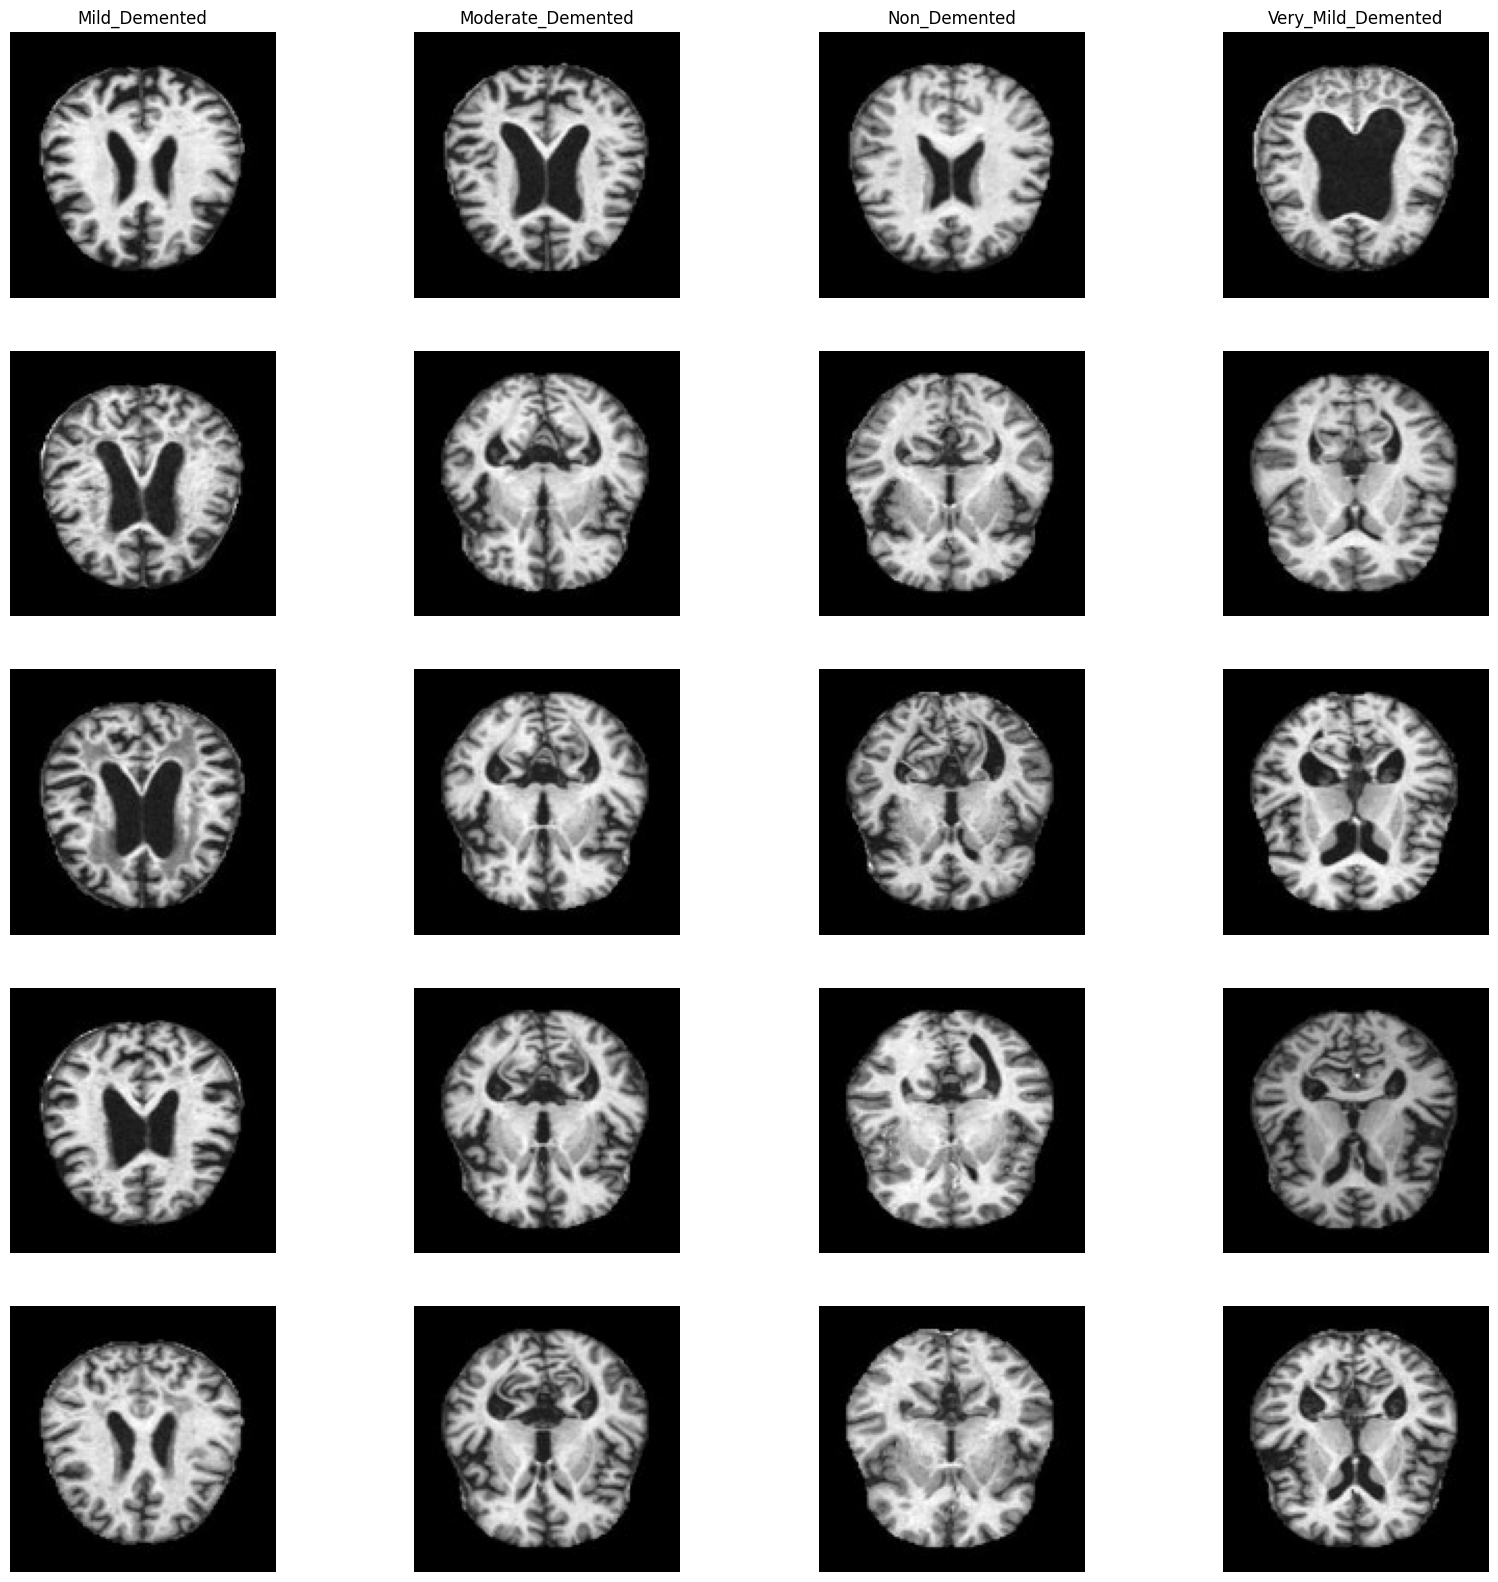

In [6]:
##### check the number of samples within each class in train set #####
# create a dictionary where:

# - keys are folder names (-> the 4 classes)
# - values are the filenames for the files in each folder : training set
imgs = {c: glob(os.path.join(train_path, c, "*")) for c in classes}
for key in imgs.keys():
   print("{} class has {} samples in train set.".format(key,len(imgs[key])))

# - keys are folder names (-> the 4 classes)
# - values are the filenames for the files in each folder :  test set
imgs = {c: glob(os.path.join(test_path, c, "*")) for c in classes}
for key in imgs.keys():
   print("{} class has {} samples in test set.".format(key,len(imgs[key])))


# PROPORTION IS RESPECTED

##### plot 5 samples per class #####
# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES
nrows = 5
fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i, (c, fnames) in enumerate(imgs.items()): # i is the count, (c, fnames) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname = (fnames[n]).replace('\\','/')
        im = Image.open(fname)
        # im = im.convert('L') # image is already saved in 'L' mode
        axs[n,i].imshow(im, cmap='gray')
for ax in axs.flatten():
    ax.axis("off")

# NEW: A BETTER LOOK AT DATA !
NEW: We have a deeper esploratory data analysis


NEW: We define a function to extract our observations and labels from dataset format required by keras. We chose to keep this format for the Dataset as it is required as model input. We basically extend  alist of data  observations (all_images) and a  list of data targets (all_labels)

In [7]:
##### extract numpy arrays of images and labels from tensorflow Dataset Object #####
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


def images_labels_fromDataset(dataset):
    dataset_it = dataset.as_numpy_iterator() # Numpy iterator, the object in input is not iterable
    all_labels=[]; all_images=[]
    for batch_images, batch_labels in dataset_it:
        all_labels.extend(batch_labels)
        all_images.extend(batch_images)
    return all_images, all_labels

tensors_train, labels_train = images_labels_fromDataset(train_ds)
tensors_val, labels_val = images_labels_fromDataset(val_ds)

In [8]:
print(len(labels_train))
print(len(tensors_train))
print(tensors_train[0].shape) # to check it is correct
print(BATCH_SIZE)

# everything is correct

4096
4096
(128, 128, 3)
102


NEW: we look better at a single observation = a single tensor. We check its shape, verify it is 2D (channels are three but identicals), compute maximum, minimum, mean. We find that images are scaled in the range [0, 255]

In [9]:
# have a close look at the format of the tensors data and at their values
s=tensors_train[0].shape  # (128,128,3)

example=tensors_train[0]   #3darray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]

check=np.count_nonzero(example[:,:,1]!=example[:,:,2]) #0
check2=np.count_nonzero(example[:,:,1]!=example[:,:,0]) #0 
# it's a tensor with three identical channels

maxvalue=np.max(example)
minvalue=np.min(example)
meanvalue=np.mean(example)

#image values
print('maxvalue: '+str(maxvalue))
print('minvalue: '+str(minvalue))
print('meanvalue: '+str(meanvalue))

maxvalue: 255.0
minvalue: 0.0
meanvalue: 69.81329


NEW: We check for classes unbalances and plot an histogram of classes distribution. Two subplots: percentage of samples per class and number of samples per class

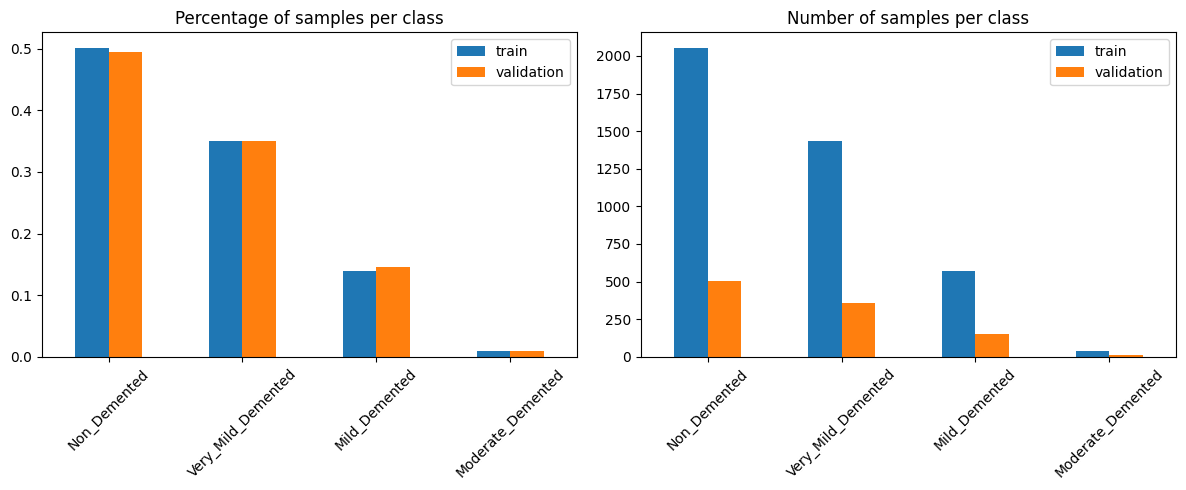

<Figure size 640x480 with 0 Axes>

In [10]:
##### check class distribution of dataset #####
train_labels_name = [classes[idx] for idx in labels_train] #name to the classes
val_labels_name = [classes[idx] for idx in labels_val]

fig,axs = plt.subplots(1,2,figsize=(12,5))

vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels_name).value_counts(normalize=vis_ratio), pd.Series(val_labels_name).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[0], title=vis_title, rot=45)
axs[0].legend(['train', 'validation'])

plt.subplot(1,2,2)
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels_name).value_counts(normalize=vis_ratio), pd.Series(val_labels_name).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[1], title=vis_title, rot=45)
axs[1].legend(['train', 'validation'])

plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('Dataset distribution.png')

In [11]:
print('Training set')
print(pd.Series(train_labels_name).value_counts())
print('Valid set')
print(pd.Series(val_labels_name).value_counts())

Training set
Non_Demented          2054
Very_Mild_Demented    1434
Mild_Demented          567
Moderate_Demented       41
Name: count, dtype: int64
Valid set
Non_Demented          506
Very_Mild_Demented    358
Mild_Demented         149
Moderate_Demented      10
Name: count, dtype: int64



NEW: IT IS possible to see how the dataset is unbalanced (few samples for moderate-dementia): it is useful to apply data aumentation in a specific manner for each class in order to prevent understimation of the minority class and consequent misleading performances.

In medical research, due to privacy concerns, the access to large data is a big problem [5], especially, the classification of cancer and AD are problematic due to lack of availability of data. It is well known that deep learning models  provide more effective results on more data. The small or imbalanced dataset  can create overfitting problems during training of the model which affects the model efficiency. To overcome this issue, we need more data to enhance the effective accuracy in our proposed model. We used the augmentation technique. 

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.
Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

NEW: the original model decides to use only AUC ROC and will later visualises it as performance metrics. STRENGHT OF ORIGINAL MODEL: AUC is a stronger indicator than accuracy, which can be misleading and doesn't account for classes unbalance. WEAKNESS OF ORIGINAL MODEL: AUC may be less informative in extremely imbalanced datasets (our case), can be high when performances on classes with less samples are worst, and our analysis showed exactly this (see Confusion Matrix of original model). In such cases, precision and recall may provide more insights into the classifier's performance on the minority class.

Moreover, AUC-ROC treats false positives and false negatives equally, but in our scenario, the cost of these errors is not the same. In AD classification, a false negative (missing a disease) might be more critical than a false positive (incorrectly predicting a disease).

# NEW: Class specific data augmentation



NEW: We define layers for data augmentations. For these, we have chosen those tranformations that we found in literature [] , but we have built only those layers that do not modify image size. For example in [5], a research work that was reference for us, they used width shift range, height shift range, shear range were applied but for us the model didn't work as image size was altered: we could have filled this with zero-padding or other filling techniques but having not any expertize and risking of making a dataset too "artificial", we decided to apply only the following transformations: random zoom in (height factor and width factot negative, see Keras documentation https://www.tensorflow.org/api_docs/python/tf/keras/layers/), random rotation, random flip, random  translation, random brightness.
Data augmentation is really adapted for our specific dataset: we could not do this inside the model, even if this would have made our model and code more transferable.

Empty spaces are filled according to attribute fill_mode: we first put fill_mode = "reflect", but looking carefully at augmented data we realised that  augmented images were not suitable for "representing" original images (looked like aliasing artifact). SO we changed fill mode= "constant" and it worked better, saving us from processing the image with operators and thresholds.  Parametre interpolation was chosen to be "bilinear" good for general-purpose smoothing but slightly blurring the image [CIT]

We set always the same seed for code repetability: this was really important here since it's about input dataset that will fit parameters.



In [12]:
## Layers for data augmentation

# randomly zoom in or out on each axis 
RandomZoom_layer1=(tf.keras.layers.RandomZoom(
    height_factor=(-0.1, -0.3),  # lower and upper bound for zooming vertically
    width_factor=(-0.1, -0.3), #lower and upper bound for zooming horizontally
    fill_mode="constant",
    seed=2023
))

# apply random rotation
RandomRotation_layer1=tf.keras.layers.RandomRotation(
    (-0.2,0.2),  #lower and upper bound for rotating clockwise and counter-clockwise. (+ counter clock-wise, - clock-wise)
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023)

# randomly flips images 
RandomFlip_layer1=tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2023)

# randomly translates images
RandomTranslation_layer1=tf.keras.layers.RandomTranslation(
    (-0.2,0.2), #height factor: lower and upper bound for shifting vertically
     (-0.2,0.2), #width factor: ower and upper bound for shifting horizontally
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023)

# randomly adjusts brightness
RandomBrightness_layer1=tf.keras.layers.RandomBrightness(
    (-0.2,0.2), seed=2023)  #lower bound and upper bound of the brightness adjustment (+ reduced brightness, - increases brightness)

NEW: The following cell is a function that saves the image, or the augmented image, that it receives as first input and puts it inside the folder assigned to "folderto".

In our first code, during data augmentation (following cell), each image, before and after being augmented, was rescaled. But while fitting the model with augmented data, we observed that validation loss became seriously divergent and the model did not work at all: we realised it was because of the rescaling (from [0, 255] to [0,1]). We concluded that the model needs to be given as input images in the range  [0, 255], not rescaled: this range is adequate to let the model learns relationship between data.


In [13]:
def save_augmented_image(image,i,label,folderto,transf=""):
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  filename = f"image_{i}_label_{label}_{transf}.jpg"  # Use a counter or other identifiers        # Create a unique filename or use some identifier based on your datase
  image_path = os.path.join(folderto, filename).replace("\\","/")  # Specify the complete path for saving the image
  tf.keras.preprocessing.image.save_img(image_path, image_array)          # Save the image
    
'''
def rescale_im(im):    #it seems that rescaling the images between 0 and 1 make the model unable to perform the training, validation loss explode
  min_value = np.min(im)
  max_value = np.max(im)
  scaled_im = (im - min_value) / (max_value - min_value)
  return scaled_im
'''

'\ndef rescale_im(im):    #it seems that rescaling the images between 0 and 1 make the model unable to perform the training, validation loss explode\n  min_value = np.min(im)\n  max_value = np.max(im)\n  scaled_im = (im - min_value) / (max_value - min_value)\n  return scaled_im\n'

In [14]:
print(classes)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


Each class has some extent of data augmentation: for example, class Non- Demented (label 2) had most samples so it was not augmented. Class Moderate Demented   (label 1) had 50 times less samples  than Non - Demented, so for each image 50 augmented images were created.  Class Very Mild Demented has a random probability condition because we didn't want to duplicate our dataset, but do "less then 2 images for image".

For the first  20 iterations, the code also shows  (unless the image was not augmented, namely unless image was labeled 2) in a raw the image and its augmented versions.


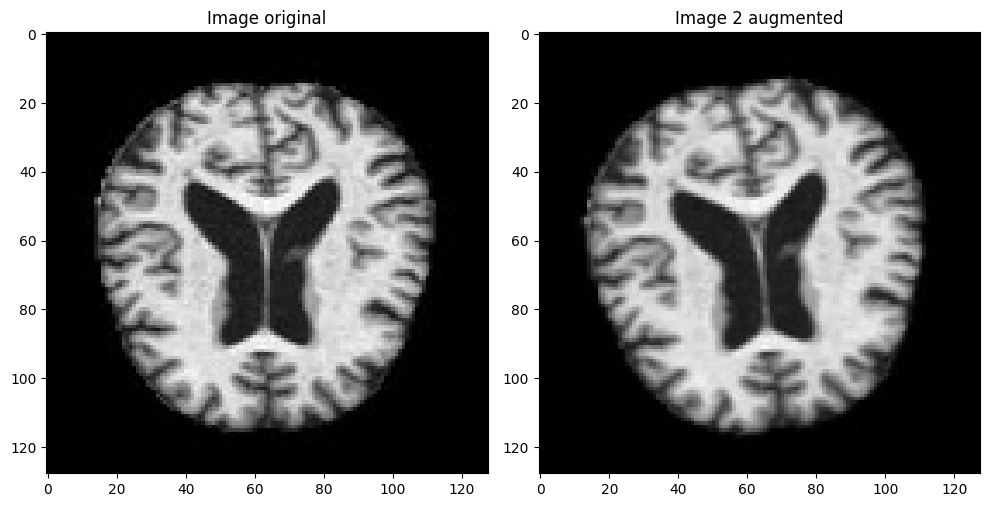

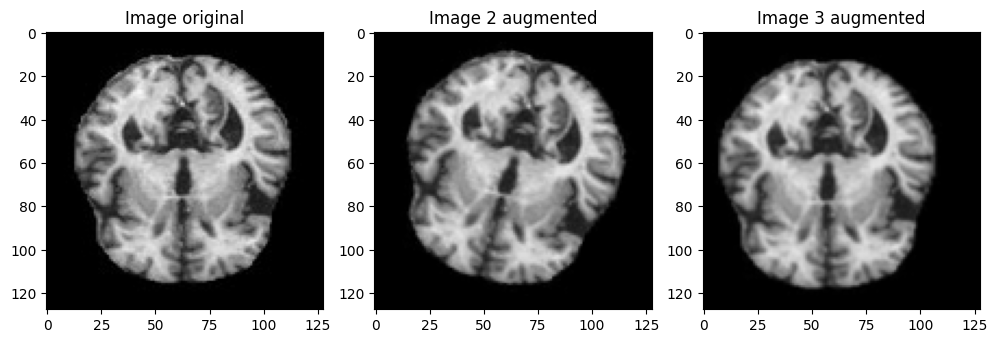

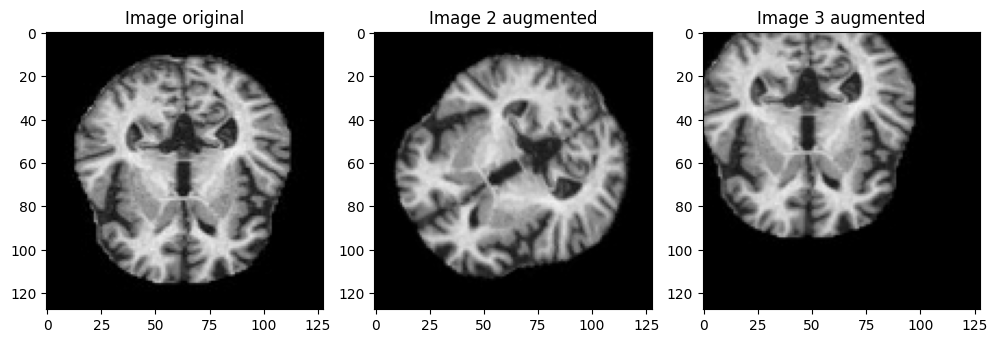

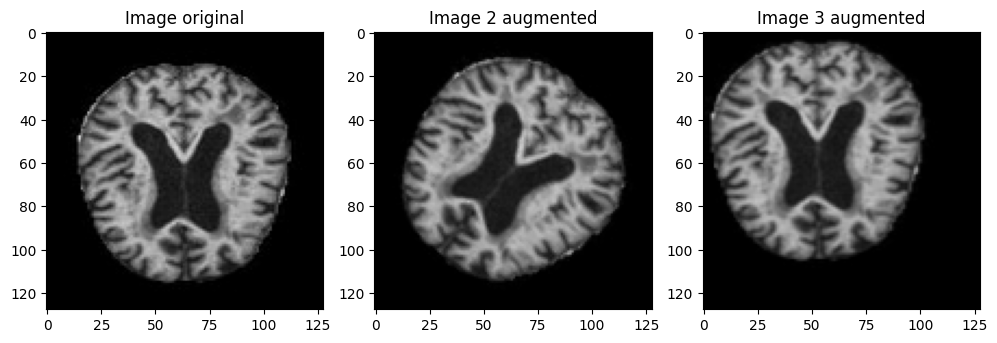

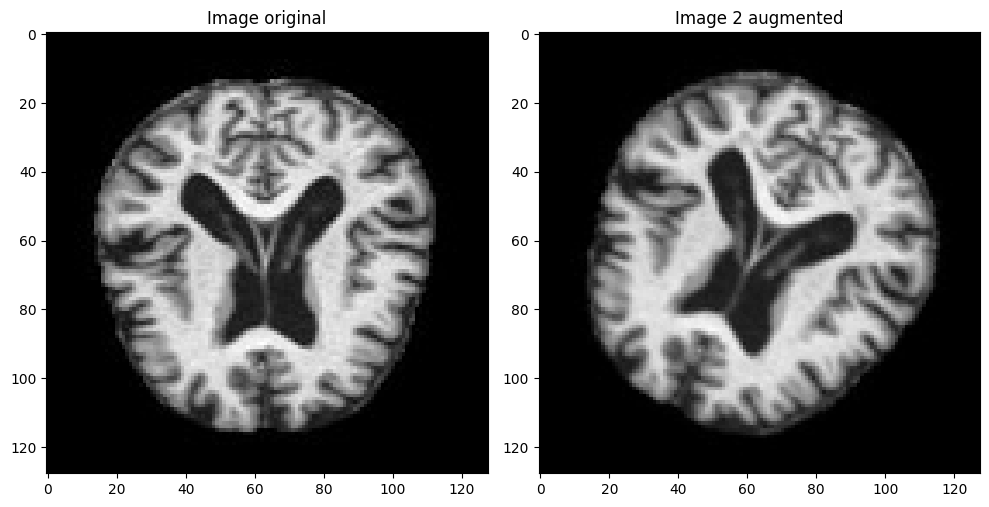

In [15]:
# DATA AUGMENTATION FOR BALANCING CLASSES

#Class - 1: Mild Demented (896 images)
#Class - 2: Moderate Demented (64 images)
#Class - 3: Non Demented (3200 images)
#Class - 4: Very Mild Demented (2240 images) 


#tensors_train, labels_train=images_labels_fromPrefetch(train_ds)   #1d array of dimension (4095)       
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> 3,6 (=4) data aug
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> 50 data aug
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> 0 data aug
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1,43 (=1) data aug




augmented_images = []
augmented_labels = []
folder_augmented_0="Augmented_TrainDataset/"+classes[0]+"/"
folder_augmented_1="Augmented_TrainDataset/"+classes[1]+"/"
folder_augmented_2="Augmented_TrainDataset/"+classes[2]+"/"
folder_augmented_3="Augmented_TrainDataset/"+classes[3]+"/"

folders_augmented=[folder_augmented_0,folder_augmented_1,folder_augmented_2,folder_augmented_3]
for f in folders_augmented:
 if not os.path.exists(f):
        os.makedirs(f)
 [os.unlink(os.path.join(f, file)) for file in os.listdir(f) if os.path.isfile(os.path.join(f, file))]


# Loop that applies  data augmentation to each image according to its label 

for i in range(len(tensors_train)): #len is 4095, first dimensions
    image = tensors_train[i]  #nd array (128,128,3)   
    label = labels_train[i]
    # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented
        augmented_image = RandomRotation_layer1(image) #tensor 
        augmented_image2= RandomTranslation_layer1(image)                                       
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2])    
        
        # SAVE image and augmented ones
        save_augmented_image(image,i,label,folder_augmented_0)
        save_augmented_image(augmented_image,i,label,folder_augmented_0,transf="RandRot")
        save_augmented_image(augmented_image2,i,label,folder_augmented_0,transf="RandTrasl")
    if label == 1: #41 Class  2: Moderate Demented 
       augmented_image_list = [RandomRotation_layer1(image) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [RandomTranslation_layer1(image) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)   
       augmented_images_conc2=augmented_images_conc2[128:]

    
       augmented_image3_list = [RandomZoom_layer1(image)  for _ in range(10)]
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)
       augmented_images_conc3=augmented_images_conc3[128:]

       augmented_image4_list = [RandomFlip_layer1(image)  for _ in range(10)]
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       augmented_images_conc4=augmented_images_conc4[128:]


       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4], axis=0)

      # SAVE image and augmented ones
       save_augmented_image(image,i,label,folder_augmented_1,transf="RandRot"+str(n))
       n=1
       for im in augmented_image_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandRot"+str(n))
         n+=1
       n=1
       for im in augmented_image2_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandTrasl"+str(n))
         n+=1
       n=1
       for im in augmented_image3_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandZoom"+str(n))     
         n+=1
       n=1
       for im in augmented_image4_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandFlip"+str(n))  
         n+=1
    if label == 2: #2053 Class 3: Non Demented 
       augmented_image=image  #rescaled
       augmented_images_conc=augmented_image
       save_augmented_image(augmented_image,i,label,folder_augmented_2)
    if label == 3:  #1433 Class 4: Very Mild Demented.
        if (random.random()<0.3) : # random probability condition because we didn't want to duplicate our dataset
            augmented_image=RandomRotation_layer1(image)
            augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image]) 
            # SAVE image and augmented ones
            save_augmented_image(image,i,label,folder_augmented_3)
            save_augmented_image(augmented_image,i,label,folder_augmented_3,transf="RandRot")
        else:
            augmented_image=image  #rescaled
            augmented_images_conc=augmented_image
            # SAVE image and augmented ones
            save_augmented_image(augmented_image,i,label,folder_augmented_3)
       
    #Target Shape of tensor
    target_shape = s #(128 128 3)

    # Calculate the number of tensors created for each iteration (image + augmented images)
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)

    # show images in the first 20 iterations (only if actually augmented)
    if i<=20 and num_tensors!=1:
      #augmented_images_conc contains the original image and the augmented ones
      fig, axs = plt.subplots(nrows=1, ncols=num_tensors, figsize=(10, 10))
      for k in range(num_tensors):
        imtoshow=(augmented_images_resh[k]).numpy()
        imtoshow = imtoshow.astype(np.uint8)  #necessary to visualize correctly the images
        axs[k].imshow(imtoshow, cmap='gray')  
        if k==0:
           axs[k].set_title(f"Image original")
        else:
          axs[k].set_title(f"Image {k + 1} augmented")
      # Adjust layout for better spacing
      plt.tight_layout()
      # Show the plot
      plt.show()


    for el in augmented_images_resh:
       augmented_images.append(el)
    for ss in range(len(augmented_images_resh)):
       augmented_labels.append(label)

NEW: display number of samples for each class after data augmentation to compare. We use a different function (count) because augmented_labels is a nd array.

In [16]:
number_of0_after=augmented_labels.count(0)  #Class 1 : 568 Mild Demented-->  1704 Mild Demented
number_of1_after=augmented_labels.count(1)  # Class  2: 41 Moderate Demented (64 images)-->1681 Moderate Demented
number_of2_after=augmented_labels.count(2)  # Class 3: 2053 Non Demented (3200 images)--> 2053  Non Demented
number_of3_after=augmented_labels.count(3)  #Class= 4: 1433 Very Mild Demented (2240 images)--> 1860 Very Mild Demented

NUM_IMAGES_POST = []

for label in classes:
    dir_name_augmented= "Augmented_TrainDataset/"+label+"/"
    num=len([name for name in os.listdir(dir_name_augmented)])
    print("{} class has {} samples in training set, after data augmentation".format(label,num))
    NUM_IMAGES_POST.append(num)

NUM_IMAGES_POST

Mild_Demented class has 1701 samples in training set, after data augmentation
Moderate_Demented class has 1680 samples in training set, after data augmentation
Non_Demented class has 2054 samples in training set, after data augmentation
Very_Mild_Demented class has 1837 samples in training set, after data augmentation


[1701, 1680, 2054, 1837]

In [17]:
#in order to have the augmented dataset the same format of the original one
train_ds_aug = tf.data.Dataset.from_tensor_slices((augmented_images,  augmented_labels))
train_ds_aug = train_ds_aug.batch(BATCH_SIZE)
#check if the augmented dataset is well formatted 
print(type(train_ds))
print(type(train_ds_aug))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


NEW: We  plot an histogram of classes distribution  before and after data augmentation. 

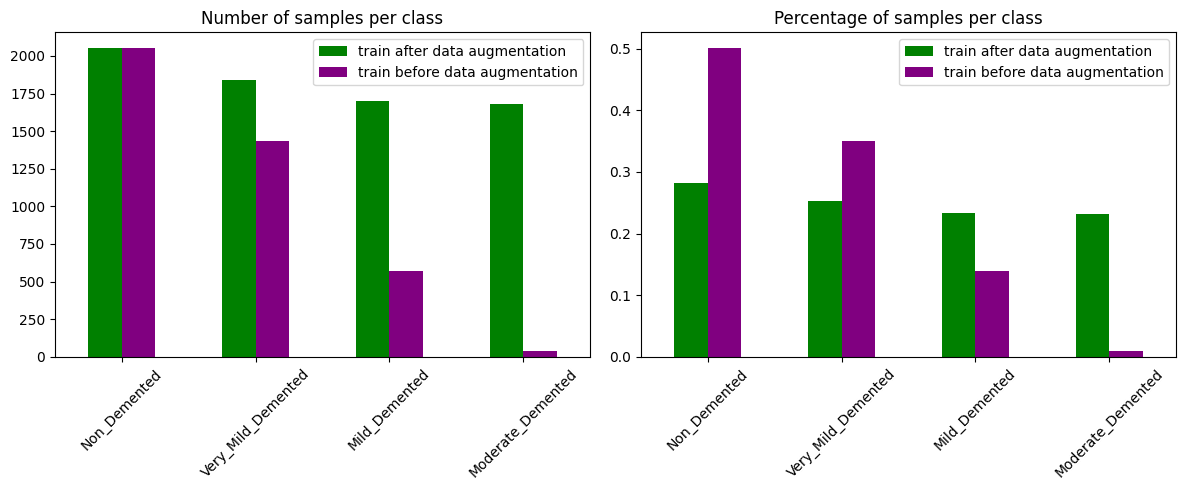

<Figure size 640x480 with 0 Axes>

In [18]:
##### plot class distribution before and after the augmentation #####
aug_tensors, aug_labels = images_labels_fromDataset(train_ds_aug)
aug_train_labels_name=['Mild_Demented' if el==0 else 'Moderate_Demented' if el==1 else 'Non_Demented'  if el==2 else 'Very_Mild_Demented'   for el in aug_labels]

fig,axs = plt.subplots(1,2,figsize=(12,5))

vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(aug_train_labels_name).value_counts(normalize=vis_ratio), pd.Series(train_labels_name).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[0], title=vis_title, rot=45, color = ['green', 'purple'])
axs[0].legend(['train after data augmentation', 'train before data augmentation'])

plt.subplot(1,2,2)
vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(aug_train_labels_name).value_counts(normalize=vis_ratio), pd.Series(train_labels_name).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[1], title=vis_title, rot=45, color = ['green', 'purple'])
axs[1].legend(['train after data augmentation', 'train before data augmentation'])

plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('Training set distribution after augmentation.png')


COMMENTS: data of class "Mild_Demented" and "Moderate_Demented" were augmented properly but their number of samples doesn't overcome the most numerous class (Non_Demented)

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

NEW The function from the origina code changes data representation in an "easier" way: converts the label into a one-hot encoded tensor (one-hot representation with a depth of NUM_CLASSES) using TensorFlow's tf.one_hot function, and returns the original image along with its one-hot encoded label. Many deep learning models can operate only on numeric variables for the algorIthm efficiency [CITAZIONE 2]. For categorical variables for which no ordinal relationship exists, as these, the integer encoding is not enough. One hot encoding converts categorical data to numbers before fitting the model: a new binary variable (column) is added to the dataset for each unique categorical value in the variable (the presence or absence of a "1" in a column indicates the class of the input sample) and the original categorical variable is removed from the dataset ; STRENGTH OF ORIGINAL CODE: this avoids introducing ordinal relationships between labels because they are treated as distinct and unrelated; here this works well since target only has 4 possible values. One more reason to apply this function is that many loss functions, such as categorical cross-entropy [citation 3] expect the target labels to be in one-hot encoded format.

In [19]:
# Function for one hot encoding of our data
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

train_ds_aug = train_ds_aug.map(one_hot_label, num_parallel_calls=AUTOTUNE)

#The following lines of code makes calling images from our dataset more efficient.
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
one_hot_tensors, one_hot_labels = images_labels_fromDataset(train_ds_aug)

In [21]:
print(one_hot_labels[0])

[0. 0. 0. 1.]


# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

NEW: we decided not to change model internal architecture (unless changing Dropout in later hyperparameters tuning) due to limited expertize and time. 
Inside the tunable model, we made dropout values of last layers scaled in proportion to "minimal units" dropout values, to respect the proportion of the chance of keeping units among layers.

In [22]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

def dense_block(units, dropout_rate, L2): # add regularization at the dense layer (dense layer has are more or less fulliconnected, is important to reguraraze weight in order to avoid overfitting)
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        tf.keras.layers.BatchNormalization(), #change the layer: is not practice use a batch normalization after a relu activation
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model_original():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7, 0),
        dense_block(128, 0.5, 0),
        dense_block(64, 0.2, 0),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

def build_model_tunable(L2,drop_out):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(drop_out),

        conv_block(256),
        tf.keras.layers.Dropout(drop_out),

        tf.keras.layers.Flatten(),
        dense_block(512, drop_out*3, L2),  # proportion of dropout between layers mantained
        dense_block(128, drop_out*2, L2),
        dense_block(64, drop_out, L2),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [23]:
#tf.keras.utils.plot_model(model, to_file="cnn.png", show_shapes=True) #plot the network

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

NEW: The original code fits the model using properly callbacks ( STRENGTH OF ORIGINAL CODE): saves a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved; keeps the model that has achieved the "best performance" so far: #stops training if a monitored metric (in this case, validation loss) does not improve after a certain number of epochs (patience).

We  plot different time decays for learning rate, assuming for example 50 epochs, to see how it decreases with epochs. We try then fitting the model with some of these learning decays and some of their parameters.



# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#save_best_only=True   #  



#early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     #restore_best_weights=True)  # VALIDATION LOSS


# patience=  Number of epochs with no improvement after which training will be stopped.
# restore_best_weights=True --> Whether to restore model weights from the epoch with the best value of the monitored quantity. If F

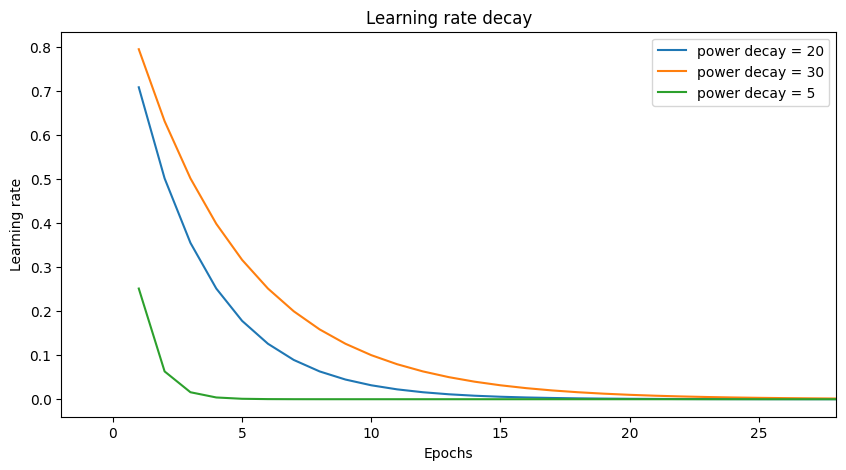

In [24]:
### plot different learning decays rates ####
def exponential_decay(s):
    def exponential_decay_fn(epoch):
        return 0.001 **(epoch / s)
    return exponential_decay_fn

epochs=np.linspace(1,50,50)
lr_epochs=0.001**(epochs / 20)
lr_epochs2=0.001**(epochs/30)
lr_epochs3=0.001**(epochs / 5)

plt.figure(figsize=(10,5))
plt.plot(epochs, lr_epochs,label="power decay = 20")
plt.plot(epochs, lr_epochs2,label="power decay = 30")
plt.plot(epochs, lr_epochs3,label="power decay = 5")

plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()
plt.xlim(-2, 28) 

plt.savefig('Learning_Rate_Decay.png')

Let's fit our model!


In [25]:
# ORIGINAL MODEL WITH ORIGINAL DATA
model_name = 'Original_model.h5'
EPOCHS = 100

import pydot
import graphviz
with strategy.scope():
    model = build_model_original()
    tf.keras.utils.plot_model(model, to_file="Original_modelplotted.png", show_shapes=True) #plot the network
    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 12.0913 - auc: 0.6475

c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 158s 4s/step - loss: 12.0913 - auc: 0.6475 - val_loss: 50978079232753664.0000 - val_auc: 0.5666 - lr: 1.0000
Epoch 2/100
41/41 [==============================] - 107s 3s/step - loss: 3.2747 - auc: 0.7344 - val_loss: 63601779933184.0000 - val_auc: 0.6631 - lr: 0.7079
Epoch 3/100


KeyboardInterrupt: 

# NEW: MODEL TRAINED WITH AUGMENTED DATA

In [147]:
# ORIGINAL MODEL WITH AUGMENTED DATA
model_name = 'Original_model_augmented_data.h5'
EPOCHS = 100

with strategy.scope():
    model_aug = build_model_original()
    
    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model_aug.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original_AUG = model_aug.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds_aug,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

Epoch 1/100
72/72 [==============================] - 124s 2s/step - loss: 18.7732 - auc: 0.5188 - val_loss: 8342285312.0000 - val_auc: 0.3692 - lr: 1.0000
Epoch 2/100
72/72 [==============================] - 116s 2s/step - loss: 1.9783 - auc: 0.5595 - val_loss: 57.6365 - val_auc: 0.4304 - lr: 0.7079
Epoch 3/100
72/72 [==============================] - 114s 2s/step - loss: 1.5091 - auc: 0.5815 - val_loss: 3.4653 - val_auc: 0.2899 - lr: 0.5012
Epoch 4/100
72/72 [==============================] - 114s 2s/step - loss: 1.4810 - auc: 0.5840 - val_loss: 1.4441 - val_auc: 0.6060 - lr: 0.3548
Epoch 5/100
72/72 [==============================] - 114s 2s/step - loss: 1.4492 - auc: 0.5937 - val_loss: 1.0748 - val_auc: 0.8051 - lr: 0.2512
Epoch 6/100
72/72 [==============================] - 113s 2s/step - loss: 1.3605 - auc: 0.6112 - val_loss: 1.2511 - val_auc: 0.7322 - lr: 0.1778
Epoch 7/100
72/72 [==============================] - 113s 2s/step - loss: 1.3629 - auc: 0.6048 - val_loss: 1.1531 - val

# NEW: HYPERPARAMETER TUNING
We try to change the model hyperparameters (drop out, L2 regularization and learnong rate decay s) in order to overcome the problem of overfitting end try to improve the given model. The initial idea was to perform a K-cross-validation but it is too time consuming, so once test and train set were fixed we tried different combinations of hyperparameters and based on the metrics plots  (AUC and loss valid / train) we chose the best one with manual visual evaluation.

The following cell only

In [148]:
#Hyperparameter tuning with augmented data
'''
drop_out = [0.1, 0.2, 0.3]   #grid of hyperparameter used to train the model
s = [5, 20, 30]
L2 = [1e-4, 1e-3, 1e-2]
'''
drop_out = [0.1]    #selected hyperparameters
s = [20]
L2 = [1e-3]

EPOCHS = 40

hparam = {
    'drop_out' : drop_out,
    's' : s,
    'L2' : L2
}

hparam_grid = ParameterGrid(hparam)

history = dict()

for p in hparam_grid:
    drop_out = p['drop_out']
    s = p['s']
    L2 = p['L2']

    model_name = 's_'+str(s)+'_L2_'+str(L2)+'_dropOut_'+str(drop_out)+'.h5'

    with strategy.scope():
        model_tuned = build_model_tunable(L2,drop_out)
        tf.keras.utils.plot_model(model_tuned, to_file=model_name[:-3]+'plotted.png', show_shapes=True) #plot the network
        METRICS = [tf.keras.metrics.AUC(name='auc')]

        model_tuned.compile(
            optimizer='adam',
            loss=tf.losses.CategoricalCrossentropy(),
            metrics=METRICS
        )

    exponential_decay_fn = exponential_decay(s)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

    history[model_name] = model_tuned.fit(        #for each epochs the data are shuffled and a portion is used as valid test
        train_ds_aug,
        batch_size = BATCH_SIZE,
        validation_data=val_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
        verbose = 1, #progression bar
        epochs=EPOCHS
    )


Epoch 1/40
72/72 [==============================] - 120s 2s/step - loss: 757.1991 - auc: 0.5291 - val_loss: 95687663616.0000 - val_auc: 0.3399 - lr: 1.0000
Epoch 2/40
72/72 [==============================] - 113s 2s/step - loss: 149.4068 - auc: 0.5780 - val_loss: 54963.8828 - val_auc: 0.4298 - lr: 0.7079
Epoch 3/40
72/72 [==============================] - 114s 2s/step - loss: 69.7286 - auc: 0.6105 - val_loss: 115.1383 - val_auc: 0.7975 - lr: 0.5012
Epoch 4/40
72/72 [==============================] - 113s 2s/step - loss: 16.0903 - auc: 0.6358 - val_loss: 368.5667 - val_auc: 0.2800 - lr: 0.3548
Epoch 5/40
72/72 [==============================] - 114s 2s/step - loss: 29.8915 - auc: 0.6280 - val_loss: 39.9954 - val_auc: 0.4306 - lr: 0.2512
Epoch 6/40
72/72 [==============================] - 113s 2s/step - loss: 16.1003 - auc: 0.6630 - val_loss: 15.3653 - val_auc: 0.2291 - lr: 0.1778
Epoch 7/40
72/72 [==============================] - 113s 2s/step - loss: 7.5157 - auc: 0.6613 - val_loss: 8.

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

NEW: We analyze the metrics also for the new models.

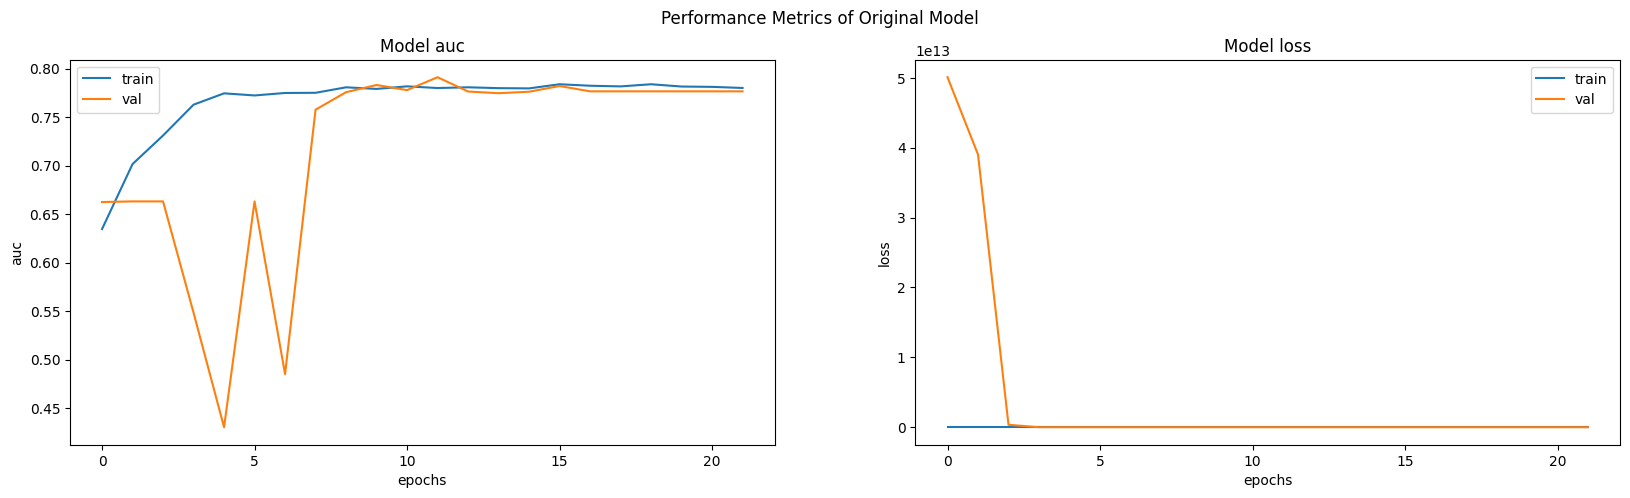

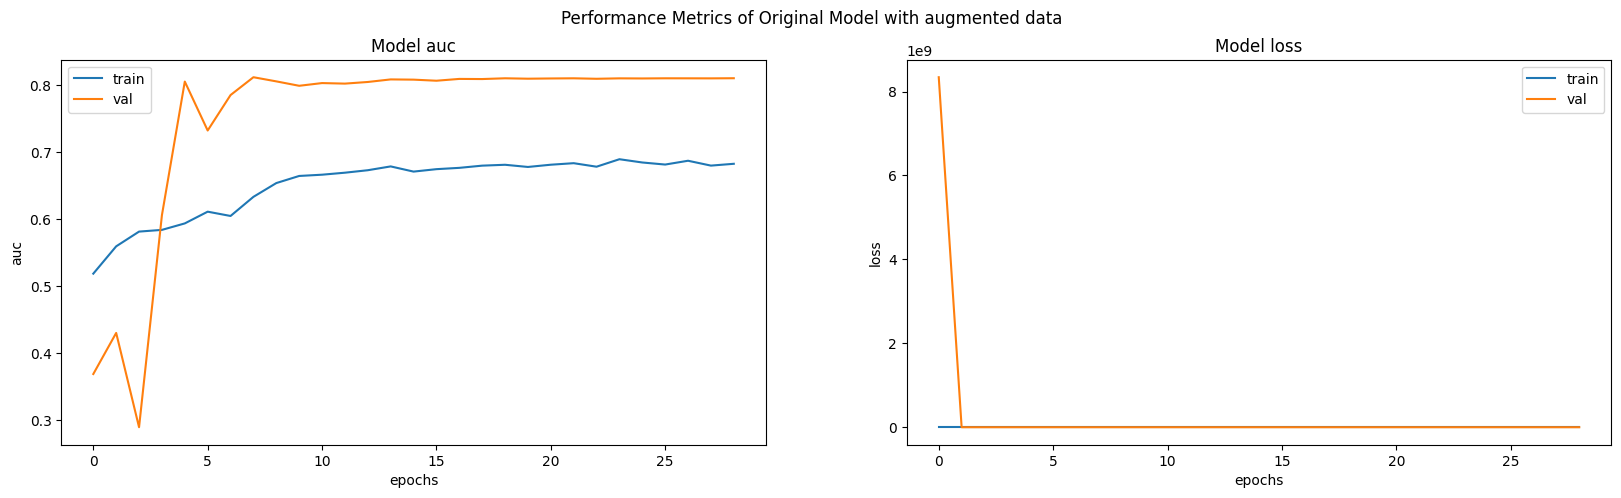

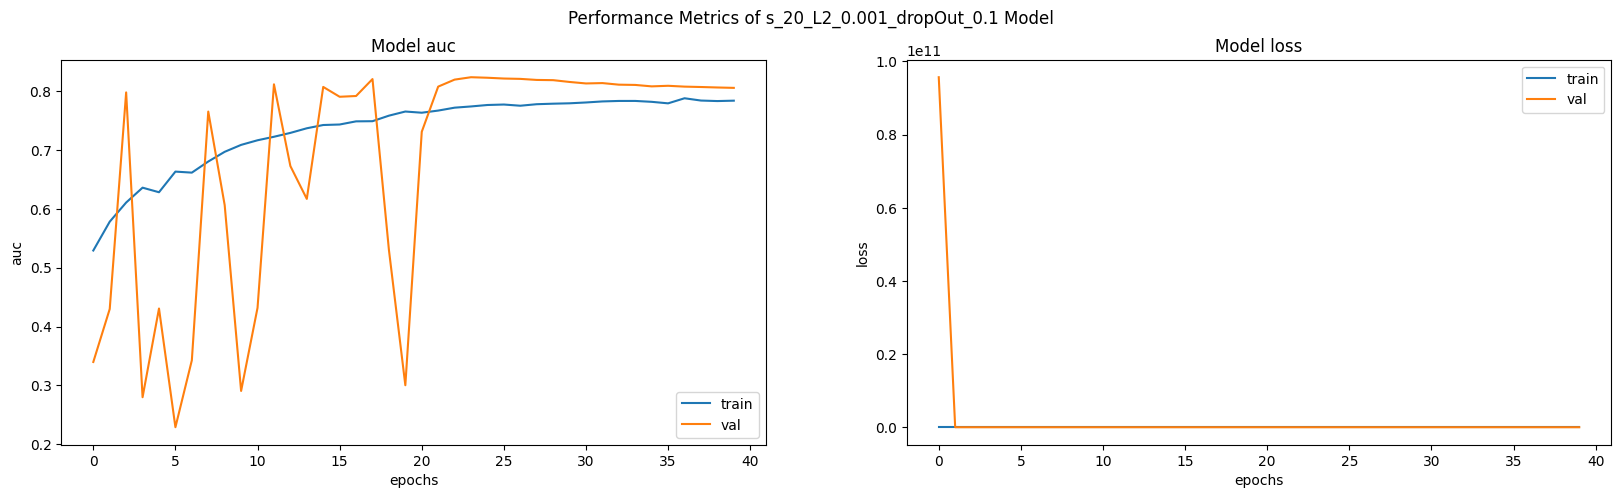

In [150]:
# Original model
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original.history[met])
    ax[i].plot(history_original.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model')
plt.savefig('Original_model.png')


# Original model AUGMENTED DATA
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original_AUG.history[met])
    ax[i].plot(history_original_AUG.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model with augmented data')
plt.savefig('Original_model_AUG.png')


#tunable models with augmanted dataset
for k in history.keys():
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.ravel()
    for i, met in enumerate(['auc', 'loss']):
        ax[i].plot(history[k].history[met])
        ax[i].plot(history[k].history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

    plt.suptitle('Performance Metrics of '+k[:-3]+' Model')

    plt.savefig(k[:-3]+'.png')

# Evaluate the Model

NEW: Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [151]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1281 files belonging to 4 classes.


# NEW: PLOT CONFUSION MATRIX & PRINT METRICS
 
NEW: the original code simply evaluated auc and loss on test set. We also define a function to plot confusion matrix, display test loss and test accuracy , report also other classification metrics for all the models implemented ( recall, f1-score, specifity at sensitivity, Cohen's kappa )

In [152]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	#This function plot confusion matrix method from sklearn package.


	plt.figure(figsize= (12, 12))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

	plt.savefig(title+'.png')


# NEW: COMPUTE KOHEN'S KAPPA
We define a function that, given   the object confusion metrix, computes kohen's kappa. Kohen's kappa measures agrrement between raters, in our case it measures the extent to which the observed agreement between two raters (in our case, predictions and ground thruths)  exceeds the agreement that could be expected by random chance.

In [ ]:

def cohen_kappa(confusion_matrix):
    # Extract values from the confusion matrix
    a = confusion_matrix[0, 0]  # True positive
    b = confusion_matrix[0, 1]  # False positive
    c = confusion_matrix[1, 0]  # False negative
    d = confusion_matrix[1, 1]  # True negative

    # Calculate observed agreement (Po)
    po = (a + d) / (a + b + c + d)

    # Calculate marginal probabilities
    agree_rater1 = (a + c) / (a + b + c + d)
    agree_rater2 = (a + b) / (a + b + c + d)

    # Calculate expected agreement (Pe)
    pe = agree_rater1 * agree_rater2 + (1 - agree_rater1) * (1 - agree_rater2)

    # Calculate Cohen's Kappa
    kappa = (po - pe) / (1 - pe) if (1 - pe) != 0 else 1.0  # Avoid division by zero

    return kappa

NEW: display balanced accuracy

We also display balanced accuracy on the test set. Despite leveling classes, our data augmentation still produces a slighlty unbalanced training set: this is why we also check balanced accuracy

11/11 [==============================] - 3s 314ms/step - loss: 1.0416 - auc: 0.7761
Balanced Accuracy Test Set: 0.25
Train Loss:  1.0333667993545532
Train AUC:  0.7807331085205078
--------------------
Validation Loss:  1.0416054725646973
Validation AUC:  0.7760713696479797
--------------------
Test Loss:  1.0364166498184204
Test AUC:  0.7795950174331665
Confusion Matrix, Without Normalization
[[  0   0 180   0]
 [  0   0  13   0]
 [  0   0 640   0]
 [  0   0 448   0]]


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       180
 Moderate_Demented       0.00      0.00      0.00        13
      Non_Demented       0.50      1.00      0.67       640
Very_Mild_Demented       0.00      0.00      0.00       448

          accuracy                           0.50      1281
         macro avg       0.12      0.25      0.17      1281
      weighted avg       0.25      0.50      0.33      1281

11/11 [==============================] - 4s 337ms/step - loss: 1.0748 - auc: 0.8051
Balanced Accuracy Test Set: 0.2689670138888889
Train Loss:  1.069953203201294
Train AUC:  0.8118385076522827
--------------------
Validation Loss:  1.074784755706787
Validation AUC:  0.8050945401191711
--------------------
Test Loss:  1.0724151134490967
Test AUC:  0.8106824159622192
Confusion Matrix, Without Normalization
[[ 19   0 161   0]
 [  0   0  13   0]
 [ 19   0 621   0]
 [ 31   0 417   0]]


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

                    precision    recall  f1-score   support

     Mild_Demented       0.28      0.11      0.15       180
 Moderate_Demented       0.00      0.00      0.00        13
      Non_Demented       0.51      0.97      0.67       640
Very_Mild_Demented       0.00      0.00      0.00       448

          accuracy                           0.50      1281
         macro avg       0.20      0.27      0.21      1281
      weighted avg       0.29      0.50      0.36      1281

11/11 [==============================] - 4s 333ms/step - loss: 1.3407 - auc: 0.8224
Balanced Accuracy Test Set: 0.31400669642857143
Train Loss:  1.3228890895843506
Train AUC:  0.8274312615394592
--------------------
Validation Loss:  1.3406912088394165
Validation AUC:  0.8223867416381836
--------------------
Test Loss:  1.3511385917663574
Test AUC:  0.8170933127403259
Confusion Matrix, Without Normalization
[[  0   0  20 160]
 [  0   0   3  10]
 [  0   0 371 269]
 [  0   0 145 303]]
                    precision

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

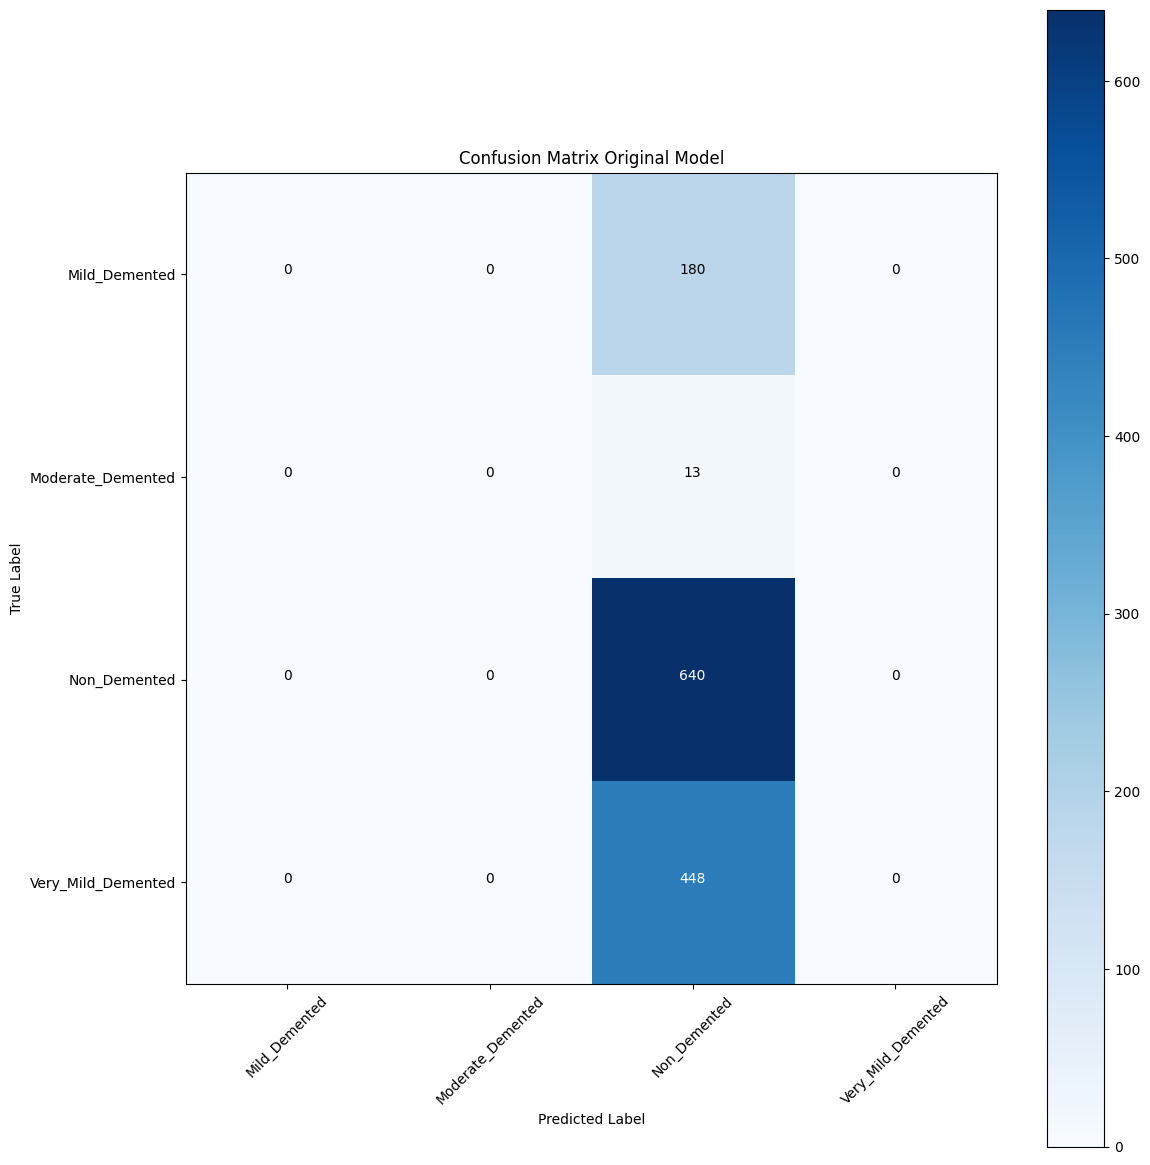

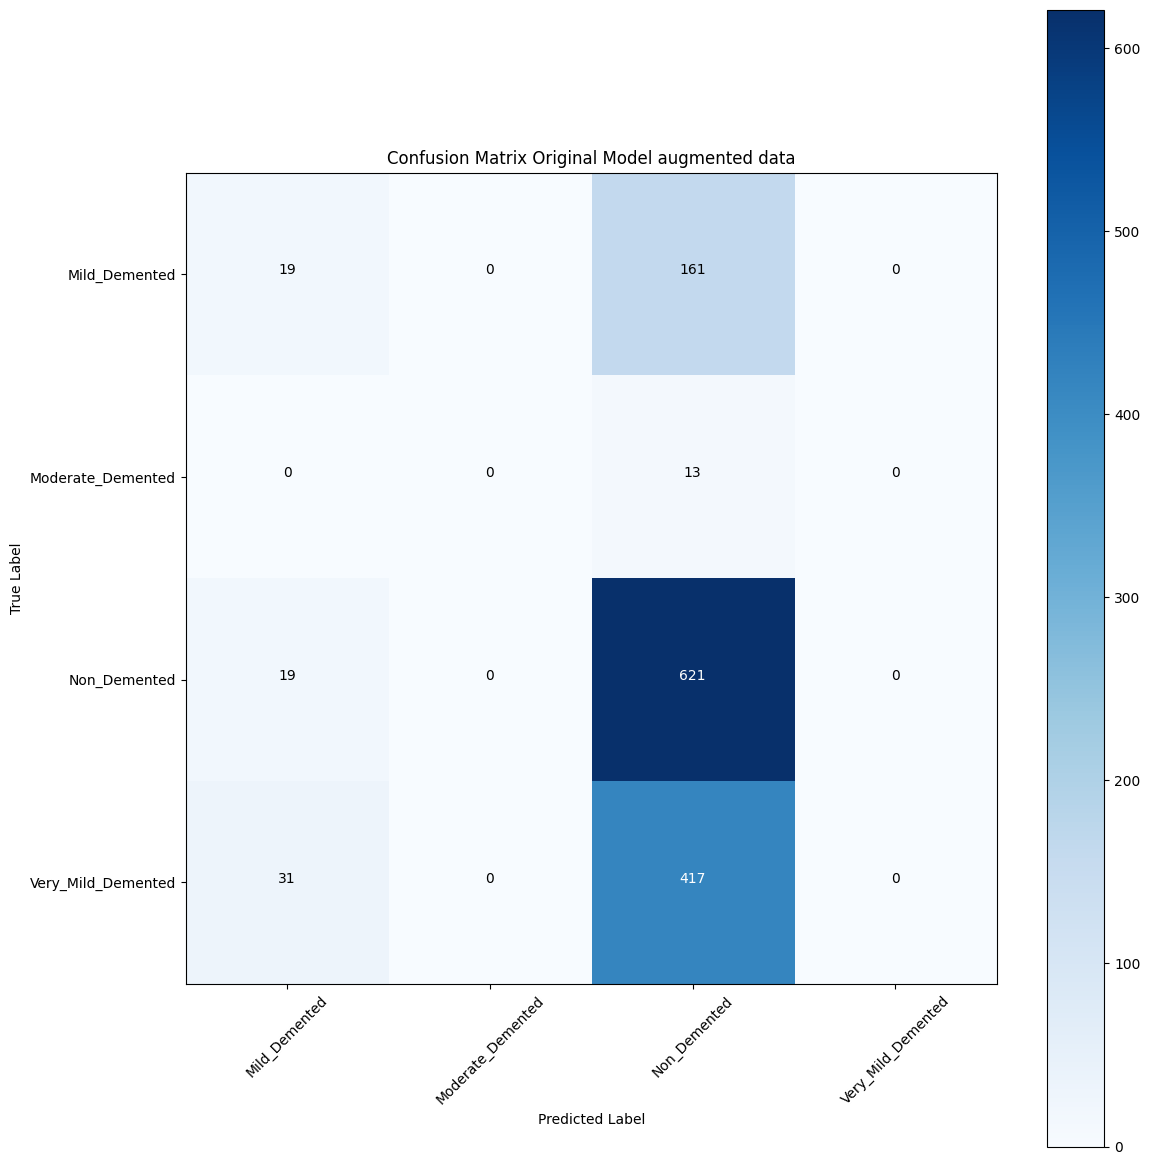

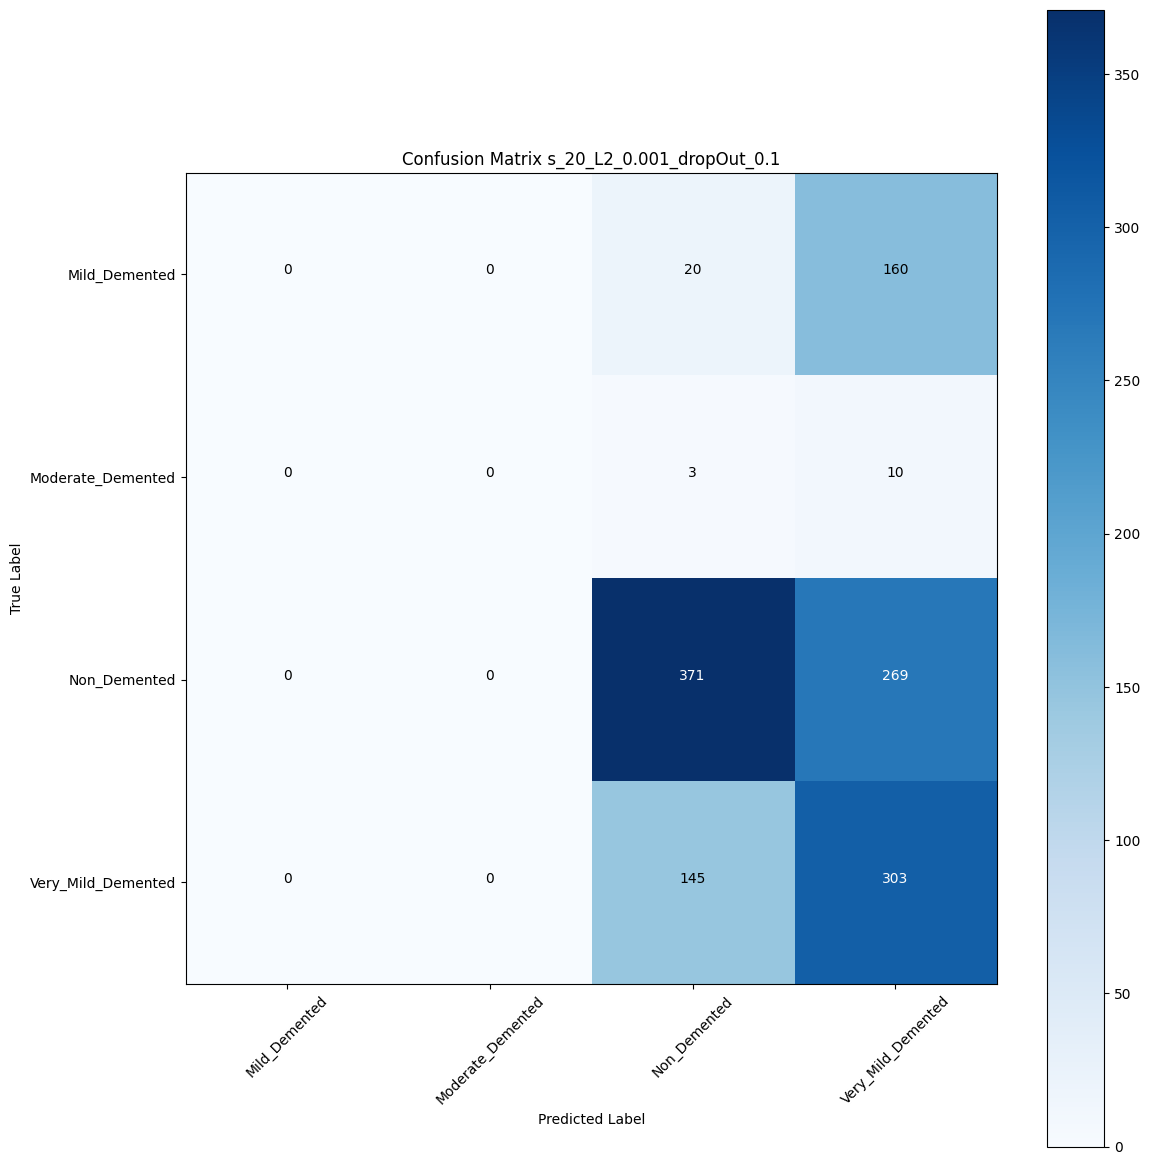

In [153]:
from sklearn.metrics import balanced_accuracy_score

tensors_test, y_true=images_labels_fromDataset(test_ds)
y_true = np.argmax(y_true, axis=1) # to reestablish the classification from the on hot encoding

# Original model 
model = load_model('Original_model.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels

train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)

balanced_acc = balanced_accuracy_score(y_true, y_pred)

print("Balanced Accuracy Test Set:", balanced_acc)
print("Train Loss: ", train_score[0])
print("Train AUC: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation AUC: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test AUC: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model')
print(classification_report(y_true, y_pred, target_names= classes))
kappa=cohen_kappa(cm)
print("Cohen's Kappa ", kappa)


# Original model with augmented data
model = load_model('Original_model_augmented_data.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels

train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)

balanced_acc = balanced_accuracy_score(y_true, y_pred)

print("Balanced Accuracy Test Set:", balanced_acc)
print("Train Loss: ", train_score[0])
print("Train AUC: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation AUC: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test AUC: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model augmented data')
print(classification_report(y_true, y_pred, target_names= classes))
kappa=cohen_kappa(cm)
print("Cohen's Kappa ", kappa)

#  Models with hyperparameters tuning:
for k in history.keys():
    model = load_model(k)
    test_score = model.evaluate(test_ds)
    test_pred = model.predict(test_ds)
    y_pred = np.argmax(test_pred, axis=1) #prediction to class labels

    train_score = model.evaluate(train_ds, verbose= 1)
    valid_score = model.evaluate(val_ds, verbose= 1)

    balanced_acc = balanced_accuracy_score(y_true, y_pred)

    print("Balanced Accuracy Test Set:", balanced_acc)
    print("Train Loss: ", train_score[0])
    print("Train AUC: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation AUC: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test AUC: ", test_score[1])

    cm= confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix '+k[:-3])
    print(classification_report(y_true, y_pred, target_names= classes))
    kappa=cohen_kappa(cm)
    print("Cohen's Kappa ", kappa)

# NEW: Transfer Learning

We use transfer learning methods to see if the usage of a more complex and pre-trained NN could lead to better performances. We use Desnet121, Resnet50, Resnet101 and Vgg19. We freezed the backbone, resized the input layer, added in order an average maxpooling layer, a dense layer activated by a Relu and the output layer in SoftMax activation.

In [154]:
img_width, img_height = 128, 128 #Our images dimensions
#Densenet121, model pretrained with the dataset imagenet, the top layer is removed, and the input shape is equal to our data's shape
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)) 
x = base_model.output #Change the output of the pretrained model
x = GlobalAveragePooling2D()(x) #Reduce the computational cost
x = Dense(1024, activation='relu')(x) #Dense Layer for output
predictions = Dense(4, activation='softmax')(x) #Final layer with the probability of each classes for every input
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: #Freeze the backbone of the model(because these layers are)
    layer.trainable = False
optimizer=Adam(learning_rate=0.001)
METRICS = [tf.keras.metrics.AUC(name='auc'),'accuracy']
model.compile(optimizer=optimizer, loss=tf.losses.CategoricalCrossentropy(), metrics=METRICS)

In [155]:
#Train the model
historydensenet101=model.fit(
    train_ds_aug,
    epochs=35,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

Epoch 1/35
72/72 [==============================] - 186s 2s/step - loss: 5.5148 - auc: 0.6460 - accuracy: 0.3941 - val_loss: 1.4724 - val_auc: 0.7218 - val_accuracy: 0.4536
Epoch 2/35
72/72 [==============================] - 174s 2s/step - loss: 1.3567 - auc: 0.7928 - accuracy: 0.5341 - val_loss: 1.0584 - val_auc: 0.8326 - val_accuracy: 0.5406
Epoch 3/35
72/72 [==============================] - 174s 2s/step - loss: 1.2190 - auc: 0.8109 - accuracy: 0.5523 - val_loss: 1.0071 - val_auc: 0.8303 - val_accuracy: 0.5259
Epoch 4/35
72/72 [==============================] - 172s 2s/step - loss: 1.0142 - auc: 0.8438 - accuracy: 0.5960 - val_loss: 1.0081 - val_auc: 0.8334 - val_accuracy: 0.5386
Epoch 5/35
72/72 [==============================] - 171s 2s/step - loss: 0.9270 - auc: 0.8611 - accuracy: 0.6156 - val_loss: 0.9362 - val_auc: 0.8452 - val_accuracy: 0.5640
Epoch 6/35
72/72 [==============================] - 171s 2s/step - loss: 0.8628 - auc: 0.8748 - accuracy: 0.6354 - val_loss: 0.9512 - v

Text(0.5, 0.98, 'Performance Metrics of DenseNet121 Model')

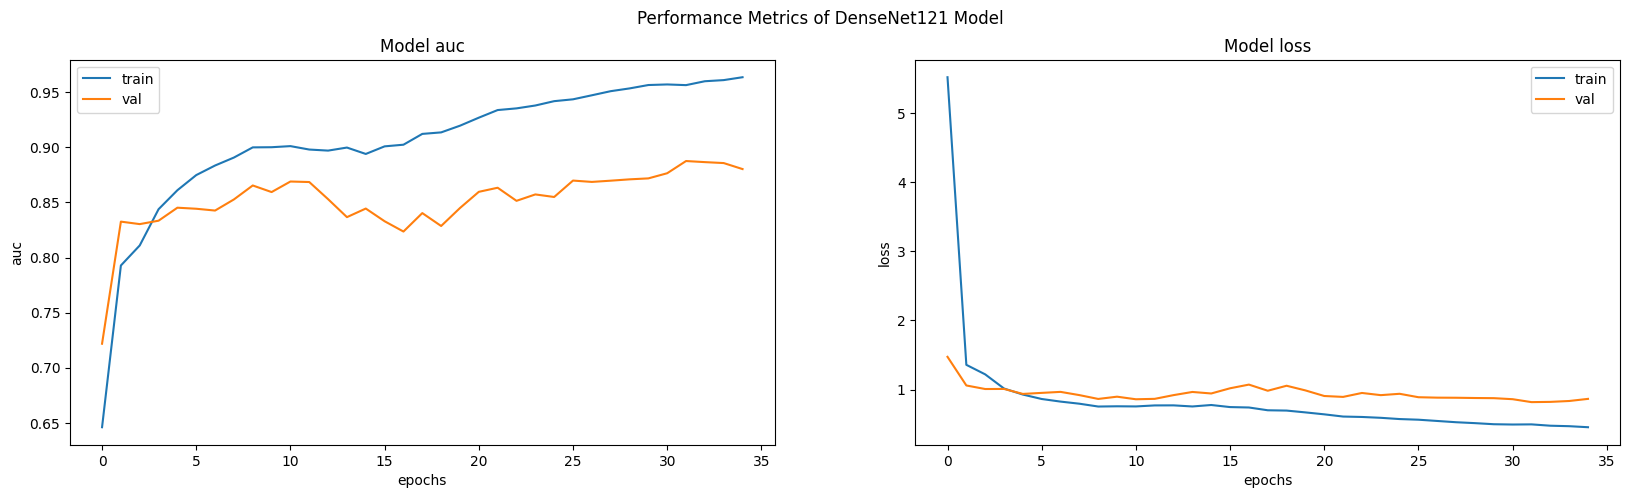

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
#Let's plot the performance metrics
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(historydensenet101.history[met])
    ax[i].plot(historydensenet101.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of DenseNet121 Model')

13/13 [==============================] - 27s 2s/step
Test Loss:  0.8391966819763184
Test Accuracy:  0.8852199912071228
Confusion Matrix, Without Normalization
[[ 97  20  38  25]
 [  1  11   1   0]
 [ 23  21 546  50]
 [ 55  36 180 177]]
                    precision    recall  f1-score   support

     Mild_Demented       0.55      0.54      0.54       180
 Moderate_Demented       0.12      0.85      0.22        13
      Non_Demented       0.71      0.85      0.78       640
Very_Mild_Demented       0.70      0.40      0.51       448

          accuracy                           0.65      1281
         macro avg       0.52      0.66      0.51      1281
      weighted avg       0.68      0.65      0.64      1281



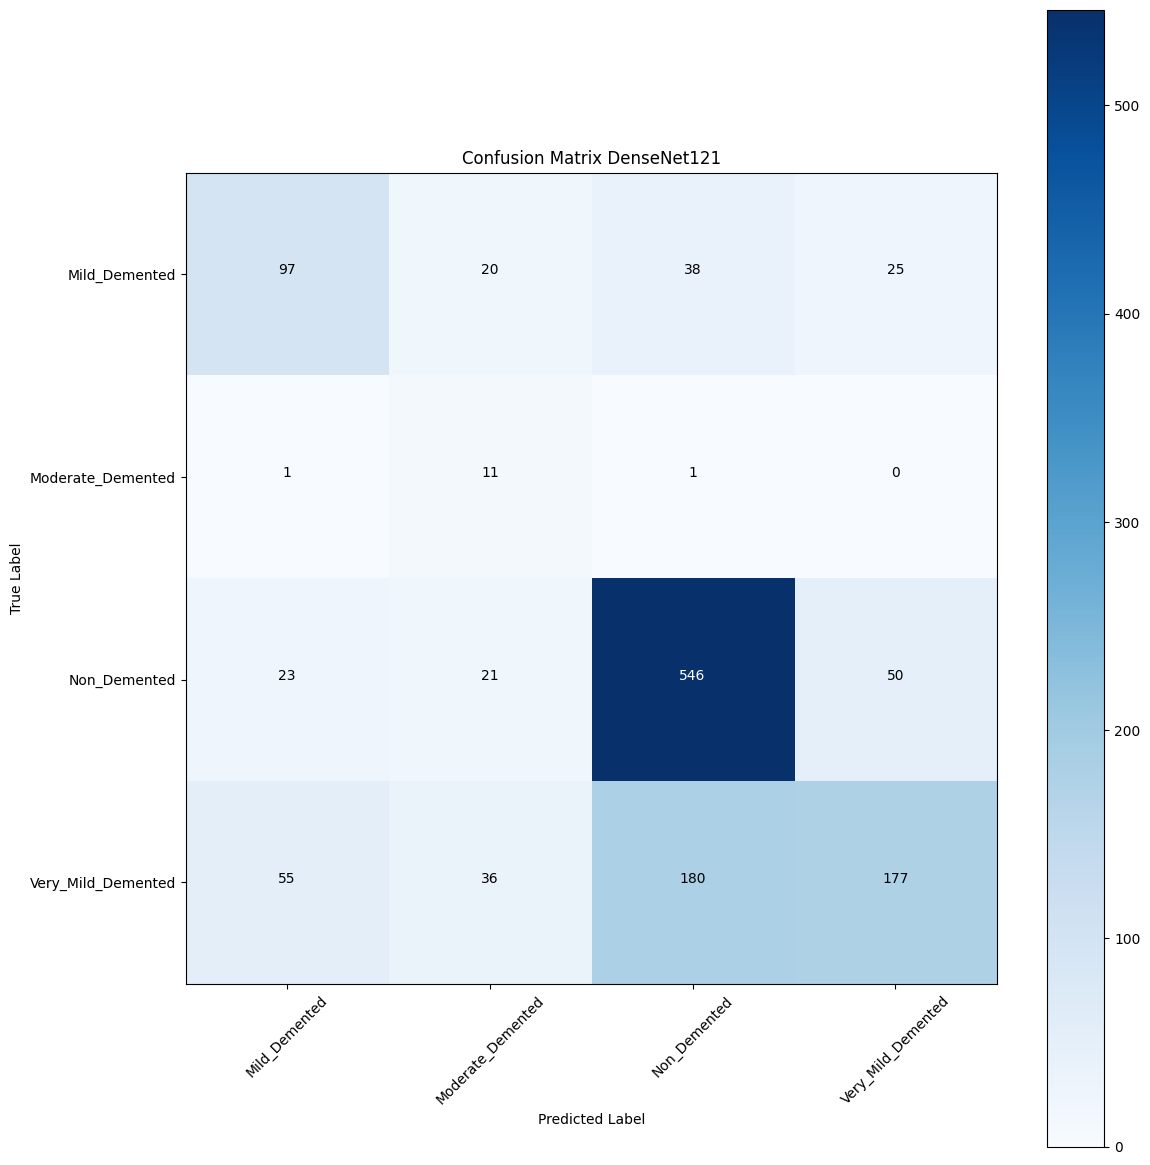

In [157]:
#Validate the model and plot the confusion matrix
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix DenseNet121')
print(classification_report(y_true, y_pred, target_names= classes))


In [158]:
#Transfer Learning with Resnet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
optimizer=Adam(learning_rate=0.001)
METRICS = [tf.keras.metrics.AUC(name='auc'),'accuracy']
model.compile(optimizer=optimizer, loss=tf.losses.CategoricalCrossentropy(), metrics=METRICS)

94765736/94765736 [==============================] - 21s 0us/step


In [159]:
#Train the model
historyresnet50=model.fit(
    train_ds_aug,
    epochs=25,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

Epoch 1/25
72/72 [==============================] - 155s 2s/step - loss: 2.3066 - auc: 0.6813 - accuracy: 0.4440 - val_loss: 1.4192 - val_auc: 0.6480 - val_accuracy: 0.3666
Epoch 2/25
72/72 [==============================] - 155s 2s/step - loss: 1.0286 - auc: 0.8106 - accuracy: 0.5419 - val_loss: 1.1084 - val_auc: 0.7733 - val_accuracy: 0.4888
Epoch 3/25
72/72 [==============================] - 153s 2s/step - loss: 0.9226 - auc: 0.8461 - accuracy: 0.5834 - val_loss: 1.0084 - val_auc: 0.8151 - val_accuracy: 0.5191
Epoch 4/25
72/72 [==============================] - 153s 2s/step - loss: 0.8573 - auc: 0.8677 - accuracy: 0.6206 - val_loss: 0.9644 - val_auc: 0.8317 - val_accuracy: 0.5357
Epoch 5/25
72/72 [==============================] - 154s 2s/step - loss: 0.8061 - auc: 0.8836 - accuracy: 0.6463 - val_loss: 0.9204 - val_auc: 0.8447 - val_accuracy: 0.5601
Epoch 6/25
72/72 [==============================] - 154s 2s/step - loss: 0.7563 - auc: 0.8978 - accuracy: 0.6681 - val_loss: 0.8895 - v

Text(0.5, 0.98, 'Performance Metrics of ResNet50 Model')

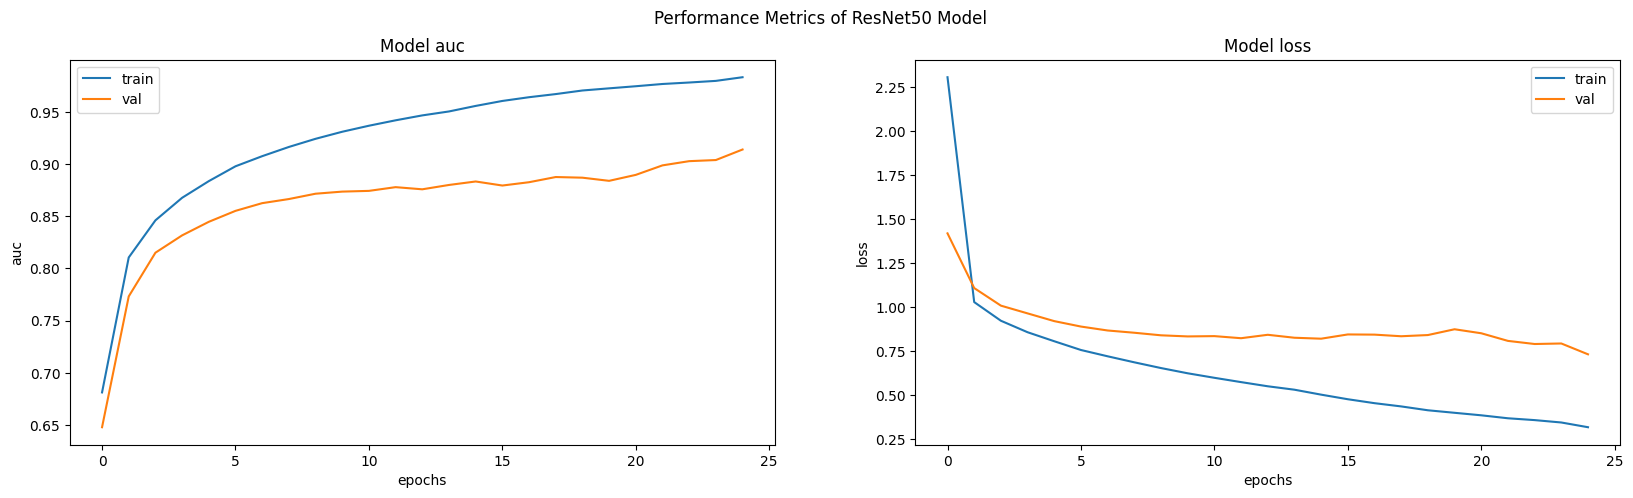

In [160]:
#Plot the performance metrics
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(historyresnet50.history[met])
    ax[i].plot(historyresnet50.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of ResNet50 Model')

13/13 [==============================] - 25s 2s/step
Test Loss:  0.7325616478919983
Test Accuracy:  0.9144982695579529
Confusion Matrix, Without Normalization
[[131   6  28  15]
 [  0  13   0   0]
 [ 42   9 557  32]
 [ 81   9 167 191]]
                    precision    recall  f1-score   support

     Mild_Demented       0.52      0.73      0.60       180
 Moderate_Demented       0.35      1.00      0.52        13
      Non_Demented       0.74      0.87      0.80       640
Very_Mild_Demented       0.80      0.43      0.56       448

          accuracy                           0.70      1281
         macro avg       0.60      0.76      0.62      1281
      weighted avg       0.73      0.70      0.68      1281



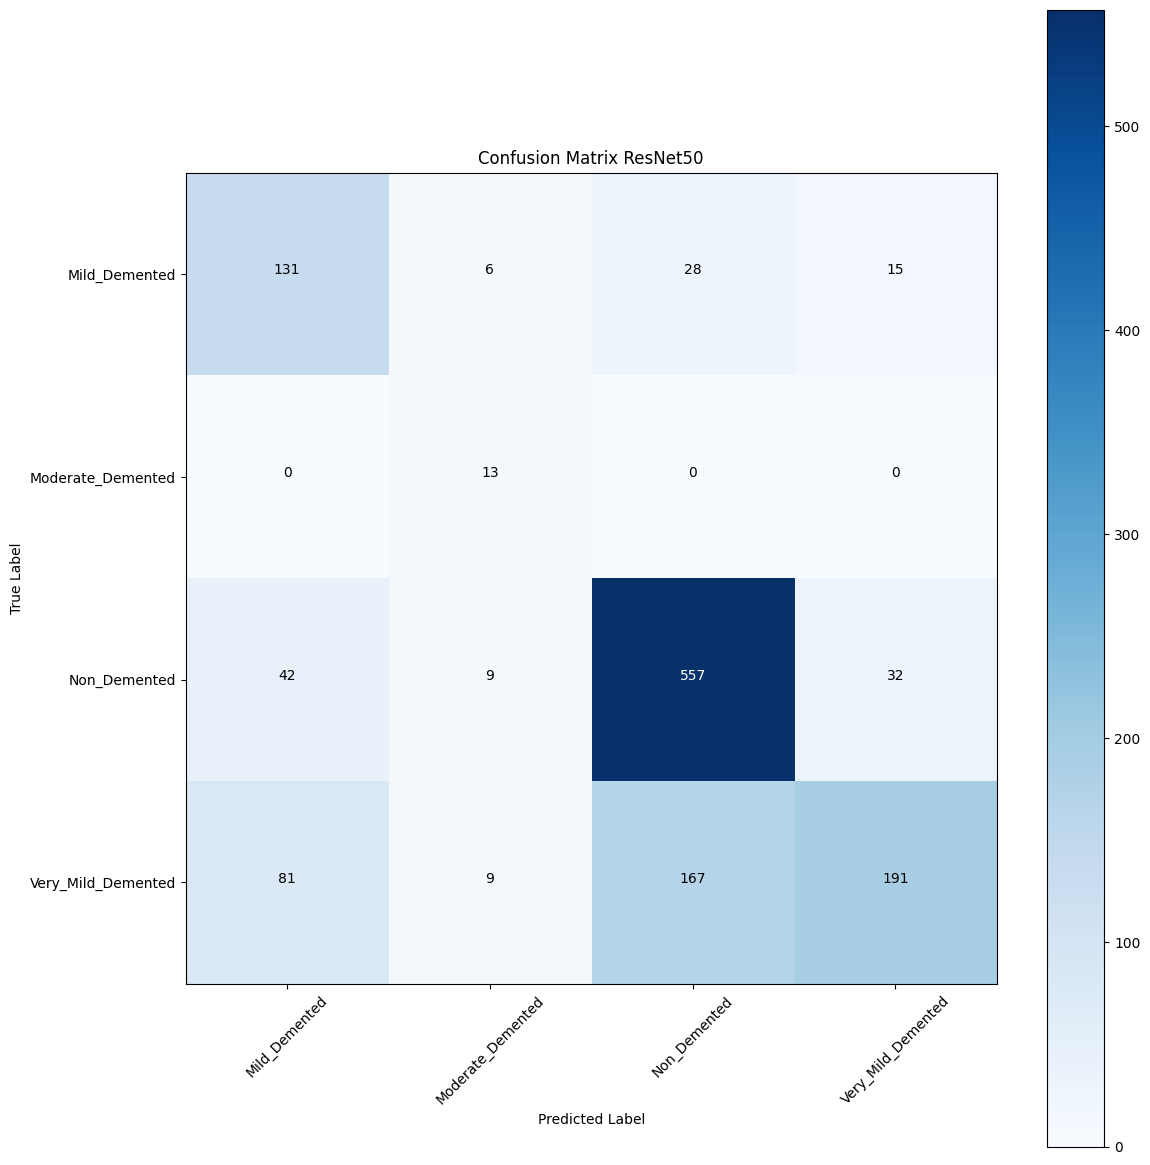

In [161]:
#Evaluate the model
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix ResNet50')
print(classification_report(y_true, y_pred, target_names= classes))

In [162]:
#Transfer Learning with Resnet101
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
optimizer=Adam(learning_rate=0.001)
METRICS = [tf.keras.metrics.AUC(name='auc'),'accuracy']
model.compile(optimizer=optimizer, loss=tf.losses.CategoricalCrossentropy(), metrics=METRICS)

171446536/171446536 [==============================] - 33s 0us/step


In [163]:
#Train model
historyresnet101=model.fit(
    train_ds_aug,
    epochs=25,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

Epoch 1/25
72/72 [==============================] - 258s 4s/step - loss: 1.9214 - auc: 0.7263 - accuracy: 0.4651 - val_loss: 1.0089 - val_auc: 0.8196 - val_accuracy: 0.5386
Epoch 2/25
72/72 [==============================] - 255s 4s/step - loss: 0.9786 - auc: 0.8328 - accuracy: 0.5692 - val_loss: 1.0378 - val_auc: 0.8194 - val_accuracy: 0.5445
Epoch 3/25
72/72 [==============================] - 258s 4s/step - loss: 0.8745 - auc: 0.8626 - accuracy: 0.6100 - val_loss: 0.9736 - val_auc: 0.8340 - val_accuracy: 0.5767
Epoch 4/25
72/72 [==============================] - 255s 4s/step - loss: 0.8161 - auc: 0.8800 - accuracy: 0.6416 - val_loss: 0.9367 - val_auc: 0.8422 - val_accuracy: 0.5826
Epoch 5/25
72/72 [==============================] - 255s 4s/step - loss: 0.7697 - auc: 0.8929 - accuracy: 0.6579 - val_loss: 0.9046 - val_auc: 0.8536 - val_accuracy: 0.6022
Epoch 6/25
72/72 [==============================] - 256s 4s/step - loss: 0.7259 - auc: 0.9049 - accuracy: 0.6791 - val_loss: 0.8577 - v

Text(0.5, 0.98, 'Performance Metrics of ResNet101 Model')

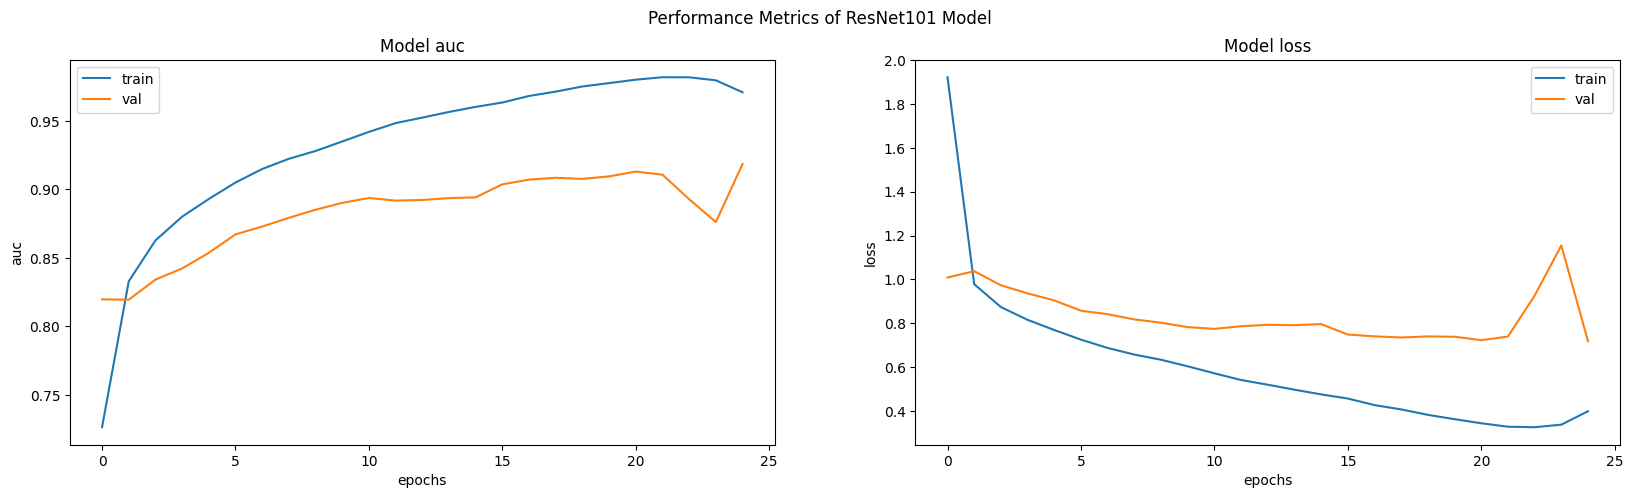

In [164]:
#Plot the metrics 
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(historyresnet101.history[met])
    ax[i].plot(historyresnet101.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of ResNet101 Model')

13/13 [==============================] - 41s 3s/step
Test Loss:  0.7411894202232361
Test Accuracy:  0.9141583442687988
Confusion Matrix, Without Normalization
[[115  13  22  30]
 [  0  13   0   0]
 [ 26   9 542  63]
 [ 51  31 132 234]]
                    precision    recall  f1-score   support

     Mild_Demented       0.60      0.64      0.62       180
 Moderate_Demented       0.20      1.00      0.33        13
      Non_Demented       0.78      0.85      0.81       640
Very_Mild_Demented       0.72      0.52      0.60       448

          accuracy                           0.71      1281
         macro avg       0.57      0.75      0.59      1281
      weighted avg       0.73      0.71      0.71      1281



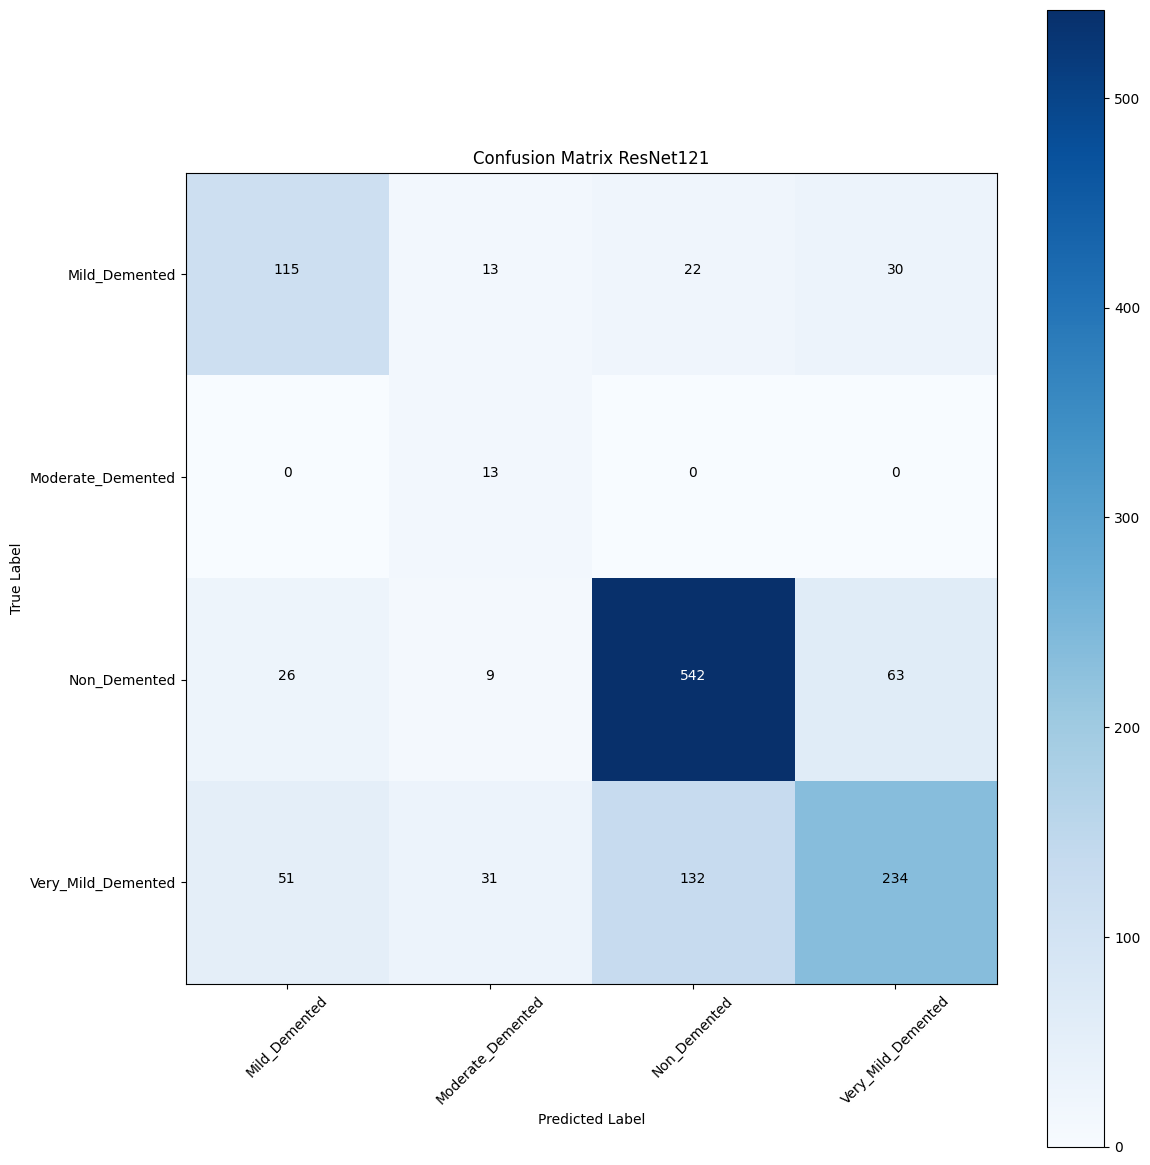

In [165]:
#Evaluate de model
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix ResNet121')
print(classification_report(y_true, y_pred, target_names= classes))

In [166]:
#Transfer Learning with VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
optimizer=Adam(learning_rate=0.001)
METRICS = [tf.keras.metrics.AUC(name='auc'),'accuracy']
model.compile(optimizer=optimizer, loss=tf.losses.CategoricalCrossentropy(), metrics=METRICS)

80134624/80134624 [==============================] - 16s 0us/step


In [167]:
#Train the model
historyVGG19=model.fit(
    train_ds_aug,
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

Epoch 1/30
72/72 [==============================] - 419s 6s/step - loss: 3.1385 - auc: 0.6946 - accuracy: 0.4541 - val_loss: 1.0173 - val_auc: 0.8288 - val_accuracy: 0.5572
Epoch 2/30
72/72 [==============================] - 417s 6s/step - loss: 0.9592 - auc: 0.8565 - accuracy: 0.6004 - val_loss: 0.9100 - val_auc: 0.8528 - val_accuracy: 0.5767
Epoch 3/30
72/72 [==============================] - 414s 6s/step - loss: 0.8273 - auc: 0.8865 - accuracy: 0.6522 - val_loss: 0.9343 - val_auc: 0.8464 - val_accuracy: 0.5758
Epoch 4/30
72/72 [==============================] - 414s 6s/step - loss: 0.8103 - auc: 0.8928 - accuracy: 0.6695 - val_loss: 0.8455 - val_auc: 0.8680 - val_accuracy: 0.6012
Epoch 5/30
72/72 [==============================] - 415s 6s/step - loss: 0.7670 - auc: 0.9031 - accuracy: 0.6872 - val_loss: 0.8214 - val_auc: 0.8757 - val_accuracy: 0.6246
Epoch 6/30
72/72 [==============================] - 415s 6s/step - loss: 0.7277 - auc: 0.9119 - accuracy: 0.6988 - val_loss: 0.8063 - v

Text(0.5, 0.98, 'Performance Metrics of VGG19 Model')

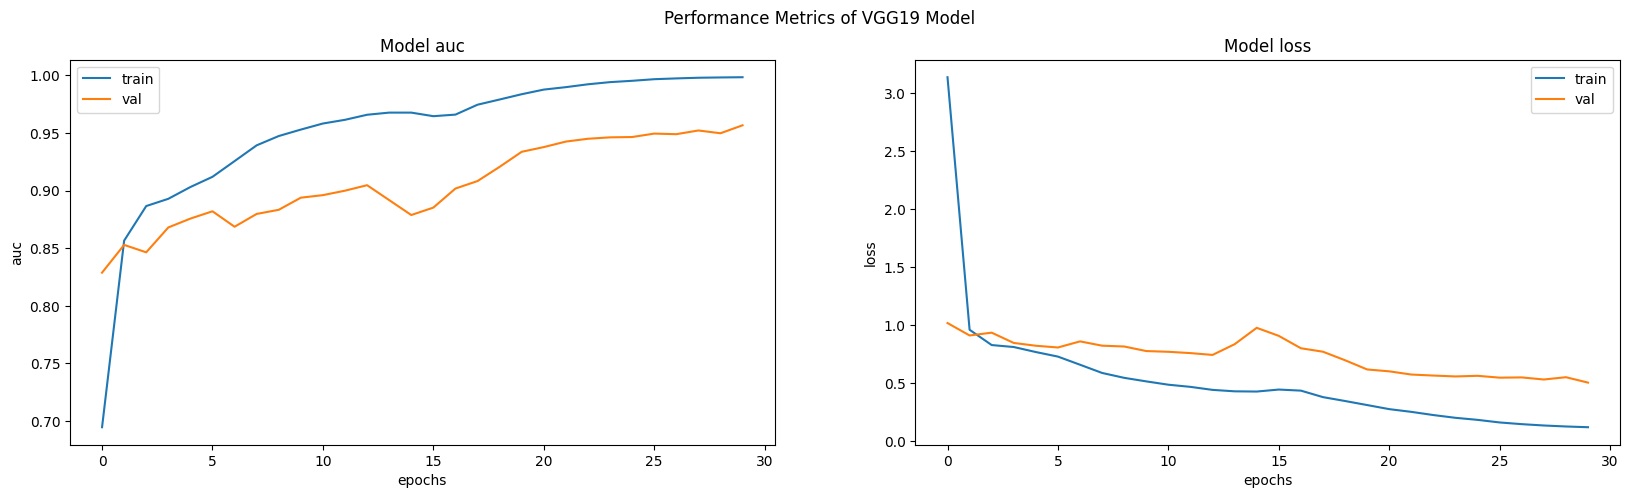

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
#Plot the performance metrics
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(historyVGG19.history[met])
    ax[i].plot(historyVGG19.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of VGG19 Model')

13/13 [==============================] - 65s 5s/step
Test Loss:  0.52994304895401
Test Accuracy:  0.9537885189056396
Confusion Matrix, Without Normalization
[[133   0  15  32]
 [  0   9   1   3]
 [ 25   1 518  96]
 [ 32   2  58 356]]
                    precision    recall  f1-score   support

     Mild_Demented       0.70      0.74      0.72       180
 Moderate_Demented       0.75      0.69      0.72        13
      Non_Demented       0.88      0.81      0.84       640
Very_Mild_Demented       0.73      0.79      0.76       448

          accuracy                           0.79      1281
         macro avg       0.76      0.76      0.76      1281
      weighted avg       0.80      0.79      0.79      1281



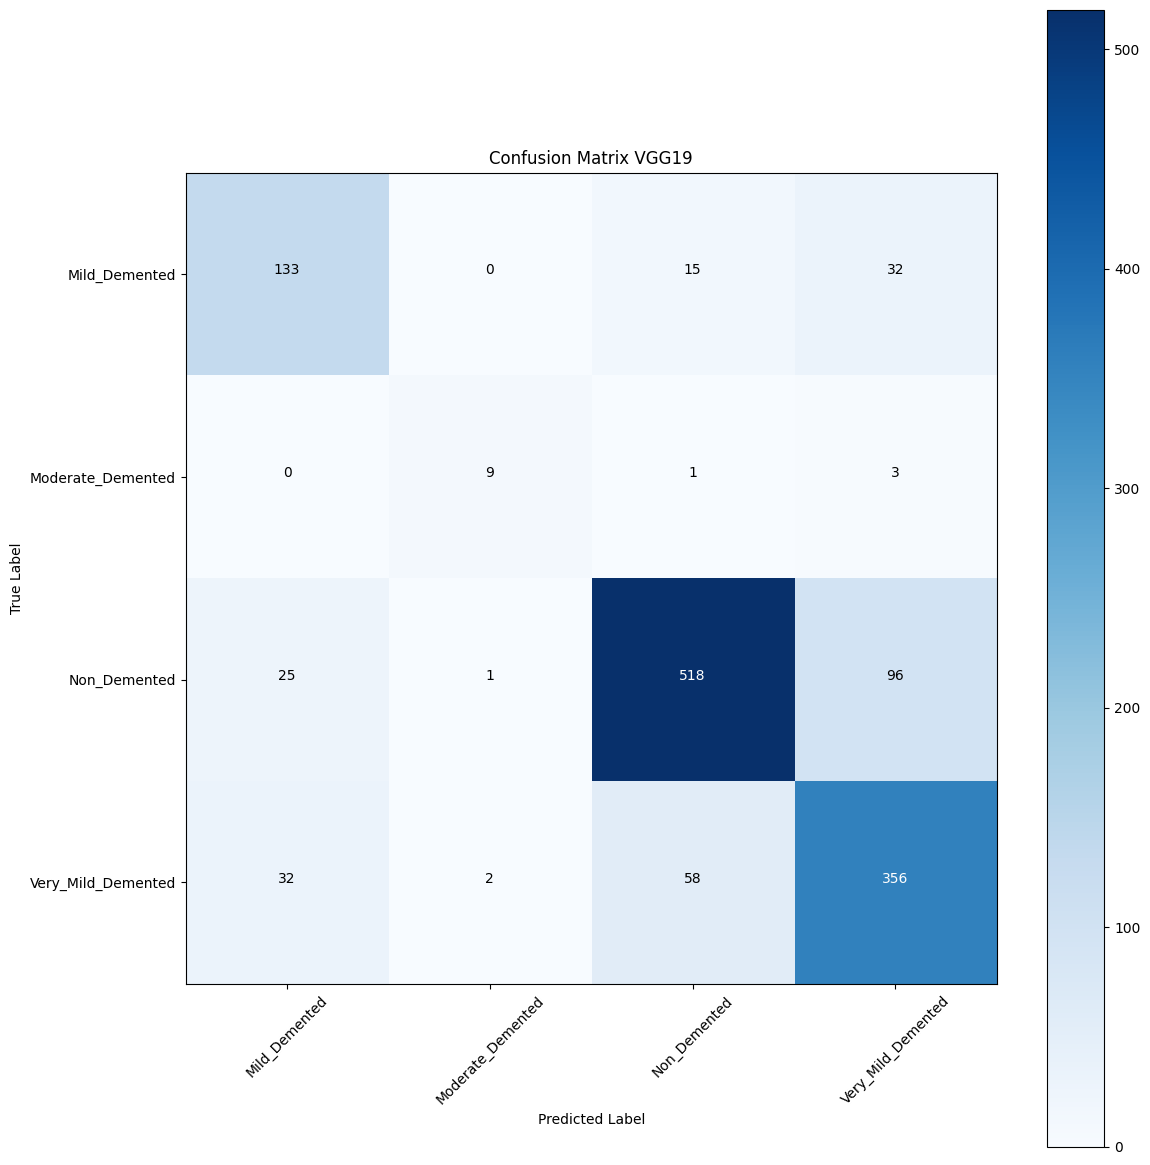

In [169]:
#Evaluate the model
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix VGG19')
print(classification_report(y_true, y_pred, target_names= classes))

# LIMITATIONS:

this code is specific for this dataset due to data augmentation that is sized on the strong unbalance of the dataset.

Using the model provided two classes are not detected even after adjusting the hyperparameters.

Data augmentation doesn't lead to any particular improovments, so we understood that the main problem is the model architecture that is unsuitable

# POSSIBLE IMPROVEMENTS

Increase the model complexity (eg. Siamese CNN [5])

Try to implement a mixed method that uses deep learning to extract features (low or high level) and an approrpiate machine learning technique that uses these features to classify the patterns.



# Results:

The original model with the new dataset struggles to identify moderate demented also using augmented data. We reach the conclusion that the model isn’t appropriate for this aim. Transfer learning techniques on different models showed higher capabilities in fulfilling the purpose of the project.


# REFERENCES
[1]Nawaz, H., Maqsood, M., Afzal, S. et al. A deep feature-based real-time system for Alzheimer disease stage detection. Multimed Tools Appl 80, 35789–35807 (2021). https://doi.org/10.1007/s11042-020-09087-y


[2]Islam, J., Zhang, Y. Brain MRI analysis for Alzheimer’s disease diagnosis using an ensemble system of deep convolutional neural networks. Brain Inf. 5, 2 (2018). https://doi.org/10.1186/s40708-018-0080-3


[3]Kundaram, Swathi S. and Ketki C. Pathak. “Deep Learning-Based Alzheimer Disease Detection.” Lecture Notes in Electrical Engineering (2020)


[4]C.H. Suh, W.H. Shim, S.J. Kim, J.H. Roh, J.-H. Lee, M.-J. Kim, S. Park, W. Jung, J. Sung, G.-H. Jahng, and for the Alzheimer’s Disease Neuroimaging Initiative. American Journal of Neuroradiology December 2020, 41 (12) 2227-2234


[5]Mehmood A, Maqsood M, Bashir M, Shuyuan Y. A Deep Siamese Convolution Neural Network for Multi-Class Classification of Alzheimer Disease. Brain Sci. 2020 Feb 5;10(2):84. doi: 10.3390/brainsci10020084


[6]Ghazal, Taher & Abbas, Sagheer & Munir, Sundus & Khan, Muhammad & Ahmad, Munir & Issa, Ghassan & Zahra, Binish & Hasan, Mohammad Kamrul. (2021). Alzheimer Disease Detection Empowered with Transfer Learning. Computers, Materials and Continua. 70. 5005-5019. 10.32604/cmc.2022.020866


[7]A. W. Salehi, P. Baglat, B. B. Sharma, G. Gupta and A. Upadhya, "A CNN Model: Earlier Diagnosis and Classification of Alzheimer Disease using MRI," 2020 International Conference on Smart Electronics and Communication (ICOSEC), Trichy, India, 2020, pp. 156-161, doi: 10.1109/ICOSEC49089.2020.9215402



[8]A. Farooq, S. Anwar, M. Awais and S. Rehman, "A deep CNN based multi-class classification of Alzheimer's disease using MRI," 2017 IEEE International Conference on Imaging Systems and Techniques (IST), Beijing, China, 2017, pp. 1-6, doi: 10.1109/IST.2017.8261460


[9] Singh, Narotam & D, Patteshwari & Soni, Neha & Kapoor, Amita. (2022). Automated detection of Alzheimer disease using MRI images and deep neural networks- A review. 10.48550/arXiv.2209.11282


[10] Nawaz, Ali & Anwar, Syed & Liaqat, Rehan & Iqbal, Javid & Majid, Muhammad. (2021). Deep Convolutional Neural Network based Classification of Alzheimer's Disease using MRI data. 
